In [142]:
import osm_manager as osmm

## Get MaStR Data

In [143]:
import pandas as pd
import numpy as np
import glob
import os
import datetime
import uuid
from functools import cache
import logging
import time
import random

import matplotlib.pyplot as plt
import matplotlib.ticker as mticker
from mpl_toolkits.basemap import Basemap
from geopy.geocoders import Nominatim

import concurrent.futures

from datetime import datetime
import json
from IPython.display import clear_output

In [144]:
SUB_DATA_PATH = "data_store/"
DATA_PATH = os.path.abspath(SUB_DATA_PATH) + "/"
SUB_DATA_PATH_MASTR = "data_store/MaStR_EDis_Erzeugungsanlagen_Data/"
DATA_PATH_MASTR = os.path.abspath(SUB_DATA_PATH_MASTR) + "/"
SUB_PLOT_SAVE_PATH = "plots/"
PLOT_SAVE_PATH = os.path.abspath(SUB_PLOT_SAVE_PATH) + "/"

SUB_EVALUATION_PATH = "data_store/cluster_eval.csv"
EVALUATION_PATH = os.path.abspath(SUB_EVALUATION_PATH)

In [145]:
# Initialize the logger
logger = logging.getLogger("info_logger")
logger.setLevel(logging.INFO)

# Create a file handler for the logger
file_handler = logging.FileHandler("info_logger.log")

# Create a formatter for the log messages
formatter = logging.Formatter("%(asctime)s - %(message)s")

# Set the formatter for the file handler
file_handler.setFormatter(formatter)

# Add the file handler to the logger
logger.addHandler(file_handler)

# Function to log a string with formatted datetime
def log_string(string):
    now = datetime.now().strftime("%Y-%m-%d %H:%M:%S")
    logger.info(f"{string}")


In [146]:
# List of major cities within the defined map boundaries - for better map orientation when plotting
cities = {
    "Berlin": (52.5200, 13.4050),
    "Leipzig": (51.3397, 12.3731),
    "Dresden": (51.0504, 13.7373),
    "Potsdam": (52.3906, 13.0645),
    "Cottbus": (51.7563, 14.3329),
    "Rostock": (54.0924, 12.0991),
    "Schwerin": (53.6355, 11.4012),
    "Greifswald": (54.0865, 13.3923),
    "Neuruppin": (52.9211, 12.8003),
    "Brandenburg": (52.4125, 12.5316)
}

# lons_span = [10.5, 15]
# lats_span = [51.5, 55]
# lat_min, lat_max = 50.5, 55
# lon_min, lon_max = 10, 15

lat_min, lat_max = 52.7, 53.35 # use for small slice north east of germany
lon_min, lon_max = 12, 12.8 # use for small slice north east of germany
# lat_min, lat_max = 47.3, 55.2 # use for all of germany
# lon_min, lon_max = 5.5, 16.0 # use for all of germany

In [147]:
# Initialize OSMDataManager for retrieving OpenStreetMap data
osm_manager = osmm.OSMDataManager()

OSMDataManager init


In [148]:
def update_and_combine_csv_files():
    # create a pattern to match all csv files
    pattern = os.path.join(DATA_PATH_MASTR, '*.csv')

    # get all csv files in the data_path_mastr
    csv_files = glob.glob(pattern)

    # create a list of dataframes
    dataframes = [pd.read_csv(csv_file, delimiter=';', on_bad_lines='skip') for csv_file in csv_files]

    # combine all dataframes in the list to one dataframe
    combined_df = pd.concat(dataframes, ignore_index=True)

    return combined_df 

In [149]:
# file_count = len(glob.glob(f"{DATA_PATH_MASTR}/*.csv"))
# print(f"Number of files in directory: {file_count}")


/Users/andreaszwikirsch/Desktop/01Uni/03BA_WS22/python_scripts/windpark_clustering/data_store/MaStR_EDis_Erzeugungsanlagen_Data/


In [150]:
# df_test = pd.read_csv(data_path + 'TEST_Stromerzeuger_1_bis_25000.csv', delimiter=';', on_bad_lines='skip')
df = update_and_combine_csv_files()

In [151]:
df.head()

,MaStR-Nr. der Einheit,Anzeige-Name der Einheit,Betriebs-Status,Energieträger,Bruttoleistung der Einheit,Nettonennleistung der Einheit,Inbetriebnahmedatum der Einheit,Registrierungsdatum der Einheit,Bundesland,Postleitzahl,...,MaStR-Nr. der Lokation,MaStR-Nr. der EEG-Anlage,EEG-Anlagenschlüssel,Inbetriebnahmedatum der EEG-Anlage,Installierte Leistung der EEG-Anlage,Zuschlagnummer (EEG/KWK-Ausschreibung),MaStR-Nr. der KWK-Anlage,Inbetriebnahmedatum der KWK-Anlage,Elektrische KWK-Leistung,Thermische Nutzleistung in kW
0,SEE941387174871,M2 Mitte 2,Endgültig stillgelegt,Wind,600,600,18/11/1999,01/11/2020,Mecklenburg-Vorpommern,17209.0,...,NaN,EEG957456916891,E41860010000000000602128046900025,18/11/1999,600,NaN,NaN,NaN,NaN,NaN
1,SEE936099477983,M3 Mitte 3,In Betrieb,Wind,600,600,30/11/1999,01/11/2020,Mecklenburg-Vorpommern,17209.0,...,SEL925200086169,EEG964782942609,E41860010000000000602128046900024,30/11/1999,600,NaN,NaN,NaN,NaN,NaN
2,SEE987954402619,M4 Mitte 4,In Betrieb,Wind,600,600,25/11/1999,01/11/2020,Mecklenburg-Vorpommern,17209.0,...,SEL925200086169,EEG921402603579,E41860010000000000602128046900023,25/11/1999,600,NaN,NaN,NaN,NaN,NaN
3,SEE960432451125,M5 Mitte 5,In Betrieb,Wind,600,600,25/11/1999,01/11/2020,Mecklenburg-Vorpommern,17209.0,...,SEL925200086169,EEG925957494996,E41860010000000000602128046900022,25/11/1999,600,NaN,NaN,NaN,NaN,NaN
4,SEE972590610139,Aufdach Windrad,In Betrieb,Wind,"1,5","1,5",27/07/2017,01/11/2020,Baden-Württemberg,72175.0,...,SEL946365780990,EEG971984240228,E10843010000000000000072266000001,27/07/2017,"1,5",NaN,NaN,NaN,NaN,NaN


In [152]:
num_rows_with_no_value = df["Name des Windparks"].isnull().sum()
print(f"Number of rows with no value in the 'Name des Windparks' column: {num_rows_with_no_value}/{len(df)}")


Number of rows with no value in the 'Name des Windparks' column: 840/35659


In [153]:
df.Bundesland.unique()

array(['Mecklenburg-Vorpommern', 'Baden-Württemberg',
       'Nordrhein-Westfalen', 'Brandenburg', 'Bayern',
       'Schleswig-Holstein', 'Niedersachsen', 'Sachsen-Anhalt',
       'Saarland', 'Rheinland-Pfalz', 'Hamburg', 'Thüringen', 'Sachsen',
       'Hessen', 'Ausschließliche Wirtschaftszone', 'Bremen', 'Berlin'],
      dtype=object)

## Data Cleaning

In [154]:
# columns_to_keep = ['MaStR-Nr. der Einheit', 'Anzeige-Name der Einheit', 'Betriebs-Status',
#        'Energieträger', 'Bruttoleistung der Einheit', 'Gemeindeschlüssel',
#        'Nettonennleistung der Einheit', 'Inbetriebnahmedatum der Einheit',
#        'Registrierungsdatum der Einheit', 'latitude', 'longitude',
#        'Hauptbrennstoff der Einheit',
#        'Letzte Aktualisierung',
#        '\tMaStR-Nr. des Anlagenbetreibers', 'MaStR-Nr. der Genehmigung',
#        'Name des Anschluss-Netzbetreibers',
#        'MaStR-Nr. des Anschluss-Netzbetreibers', 'Netzbetreiberprüfung',
#        'Spannungsebene', 'MaStR-Nr. der Lokation', 'MaStR-Nr. der EEG-Anlage', 
#        'Inbetriebnahmedatum der EEG-Anlage',
#        'Installierte Leistung der EEG-Anlage']

columns_to_keep = ['Betriebs-Status',
       'Energieträger', 'Gemeindeschlüssel', 'Nettonennleistung der Einheit', 'Bruttoleistung der Einheit',
       'Inbetriebnahmedatum der Einheit',
       'Registrierungsdatum der Einheit', 'Bundesland', 'latitude', 'longitude', 'Name des Windparks',
       'Letzte Aktualisierung', 'Name des Anlagenbetreibers (nur Org.)',
       'Name des Anschluss-Netzbetreibers',
       'MaStR-Nr. des Anschluss-Netzbetreibers',
       'Spannungsebene', 
       'Inbetriebnahmedatum der EEG-Anlage']

# to_keep_cols = ["Gemeindeschlüssel", "latitude", "longitude", "Betriebs-Status", "Registrierungsdatum der Einheit", "Letzte Aktualisierung", "Inbetriebnahmedatum der EEG-Anlage"]

Funciton to add missing coordinates of wind turbines to the dataframe

In [155]:
def add_missing_coordinates(data):
    # Load filter dict -> contains missing city location data
    with open(DATA_PATH + 'city_data_cache.json') as f:
        new_location_data = json.load(f)

    # Convert the JSON dictionary to a pandas DataFrame
    new_location_data_cache = {}
    for index, (key, value) in enumerate(new_location_data.items()):
        new_location_data_cache[index] = {
            'Gemeindeschluessel': int(key),
            'Longitude': value['Coordinates'][1],
            'Latitude': value['Coordinates'][0],
            'CityName': value['CityName']
        }

    print(f"Found {len(new_location_data_cache)} missing city location data")

    location_df = pd.DataFrame.from_dict(new_location_data_cache, orient='index')

    print("Successfully loaded city_data_cache.json data")

    # Merge location data with raw data -> assign longitude and latitude to Gemeindeschlüssel
    for row in location_df.itertuples():
        mask = (data['longitude'].isna() | data['latitude'].isna()) & (data['Gemeindeschlüssel'] == row.Gemeindeschluessel)
        data.loc[mask, 'longitude'] = row.Longitude
        data.loc[mask, 'latitude'] = row.Latitude

    print("Successfully merged location data with raw data")

    return data

### Function to categorise voltage level of data points

In [156]:
# helper functio to define Umspannebene V-SubLevel
def v_sublevel(input_str, categories):
    voltage_level_row_cache = []
    for categorie in categories:
        if categorie in input_str:
            voltage_level_row_cache.append(categorie)

In [157]:
    # Function to categorize Spannungsebene
    # Favour MS 
    VOLTAGE_LEVEL_CATEGORIES = ["Niederspannung", "Mittelspannung", "Hochspannung", "Höchstspannung"]
    UMSPANNEBENEN = ["Umspannebene Höchstspannung/Hochspannung" , "Umspannebene Hochspannung/Mittelspannung", "Umspannebene Mittelspannung/Niederspannung"]
    USE_UMSPANNEBENEN = True

    @cache
    def categorize_spannungsebene(input_str):
        # first - check if Umspannwerk
        if USE_UMSPANNEBENEN:
            if "Umspannebene" in input_str:
                print(f"Umspannebene found in {input_str}")
                for umspannebene in UMSPANNEBENEN:
                    if umspannebene in input_str:
                        return umspannebene

        # inputs_str -> vlue of Spannungsebene column of current row
        first_substr = None
        # init first_index with worst case
        first_index = len(input_str)

        # iterate over voltage level categories
        for substr in VOLTAGE_LEVEL_CATEGORIES:
            # find first occurence of substr in input_str
            index = input_str.find(substr)

            # if index is valid and smaller than first_index
            if 0 <= index < first_index:
                first_index = index
                first_substr = substr
            
        return first_substr
            
        # if 'Mittelspannung' in input_str:
        #     return 'Mittelspannung'
        # elif 'Niederspannung' in input_str:
        #     return 'Niederspannung'
        # elif 'Hochspannung' in input_str:
        #     return 'Hochspannung'
        # elif 'Höchstspannung' in input_str:
        #     return 'Höchstspannung'
        # else:
        #     return 'Other'

### Filter raw data -> return df_filtered, df_raw

In [158]:
def filter_dataframe(df):
    # edit column names -> longitude and latitude
    # TODO: Filter error datatime parser?
    missing_values = df['Inbetriebnahmedatum der Einheit'].isna().sum()
    if missing_values < int(0.25 * df.shape[0]):
        df.dropna(subset=['Inbetriebnahmedatum der Einheit'], inplace=True)
    else:
        print(f"Found {missing_values}/{df.shape[0]} missing values in 'Inbetriebnahmedatum der Einheit' column")
        # cont_flow_var = input("Do you want to continue? (y/n): ")
        # if cont_flow_var == 'n':
        #     print("Exiting program...")
        #     exit()
    
    if 'latitude' in df.columns and 'longitude' in df.columns:
        pass
    else:
        df = df.rename(columns={'Koordinate: Breitengrad (WGS84)': 'latitude', 'Koordinate: Längengrad (WGS84)': 'longitude'})
    
    longitude_dtype = df['longitude'].dtype
    latitude_dtype = df['latitude'].dtype

    if np.issubdtype(longitude_dtype, np.number) and np.issubdtype(latitude_dtype, np.number):
        print("Both 'longitude' and 'latitude' are in numerical format.")
        print(f"longitude: {longitude_dtype}, latitude: {latitude_dtype}")
    else:
        print("One or both of the 'longitude' and 'latitude' are not in numerical format.")
        # Converting them to numeric values after replacing comma with dot
        df['latitude'] = pd.to_numeric(df['latitude'].str.replace(',', '.'))
        df['longitude'] = pd.to_numeric(df['longitude'].str.replace(',', '.'))

    # convert dates to datetime
    df['Inbetriebnahmedatum der Einheit'] = pd.to_datetime(df['Inbetriebnahmedatum der Einheit'], dayfirst=True, errors='coerce')
    df.dropna(subset=['Inbetriebnahmedatum der Einheit'], inplace=True)

    # add missing coordinates
    df = add_missing_coordinates(df)

    df_raw = df.copy()
    df_raw = add_missing_coordinates(df_raw)

    # drop all rows with no coordinates
    coords_still_missing_after = df[['longitude', 'latitude']].isna().any(axis=1).sum()
    if coords_still_missing_after > 0:
        print(f"There are still {coords_still_missing_after} rows with missing longitude or latitude.")
        print("Dropping rows with missing coordinates...")
        df = df.dropna(subset=['longitude', 'latitude'])

    # convert dates to datetime
    df['Registrierungsdatum der Einheit'] = pd.to_datetime(df['Registrierungsdatum der Einheit'], dayfirst=True)
    df['Letzte Aktualisierung'] = pd.to_datetime(df['Letzte Aktualisierung'], dayfirst=True)
    df['Inbetriebnahmedatum der EEG-Anlage'] = pd.to_datetime(df['Inbetriebnahmedatum der EEG-Anlage'], dayfirst=True)
    

    # filter unnecessary columns
    df = df[columns_to_keep]

    # filter for only "In Betrieb" status
    df = df[df["Betriebs-Status"] == "In Betrieb"]
    

    # Apply the function to create a new column
    df['Spannungsebene_Category'] = df['Spannungsebene'].apply(categorize_spannungsebene)
    print("Successfully categorized Spannungsebene")

    # save cleand df to csv
    df.to_csv('cleaned_data.csv', index=False)

    return df, df_raw

print(df.shape)
df, df_raw = filter_dataframe(df)
print(df.shape)
df.head()

(35659, 50)
One or both of the 'longitude' and 'latitude' are not in numerical format.
Found 892 missing city location data
Successfully loaded city_data_cache.json data
Successfully merged location data with raw data
Found 892 missing city location data
Successfully loaded city_data_cache.json data
Successfully merged location data with raw data
There are still 848 rows with missing longitude or latitude.
Dropping rows with missing coordinates...
Umspannebene found in Umspannebene Hochspannung/Mittelspannung
Umspannebene found in Umspannebene Mittelspannung/Niederspannung
Umspannebene found in Umspannebene Hochspannung/Mittelspannung; Niederspannung (= Hausanschluss/Haushaltsstrom)
Umspannebene found in Umspannebene Höchstspannung/Hochspannung
Umspannebene found in Hochspannung; Hochspannung; Umspannebene Hochspannung/Mittelspannung
Umspannebene found in Umspannebene Hochspannung/Mittelspannung; Umspannebene Hochspannung/Mittelspannung; Umspannebene Hochspannung/Mittelspannung; Umspan

,Betriebs-Status,Energieträger,Gemeindeschlüssel,Nettonennleistung der Einheit,Bruttoleistung der Einheit,Inbetriebnahmedatum der Einheit,Registrierungsdatum der Einheit,Bundesland,latitude,longitude,Name des Windparks,Letzte Aktualisierung,Name des Anlagenbetreibers (nur Org.),Name des Anschluss-Netzbetreibers,MaStR-Nr. des Anschluss-Netzbetreibers,Spannungsebene,Inbetriebnahmedatum der EEG-Anlage,Spannungsebene_Category
1,In Betrieb,Wind,13071023.0,600,600,1999-11-30,2020-11-01,Mecklenburg-Vorpommern,53.333643,12.485184,BÜ Bütow,2022-07-26,Windfeld Bütow/Zepkow GmbH & Co. 1. Betreiber KG,E.DIS Netz GmbH (SNB941690671609),SNB941690671609,Umspannebene Hochspannung/Mittelspannung,1999-11-30,Umspannebene Hochspannung/Mittelspannung
2,In Betrieb,Wind,13071023.0,600,600,1999-11-25,2020-11-01,Mecklenburg-Vorpommern,53.331335,12.485644,BÜ Bütow,2022-07-26,Windfeld Bütow/Zepkow GmbH & Co. 1. Betreiber KG,E.DIS Netz GmbH (SNB941690671609),SNB941690671609,Umspannebene Hochspannung/Mittelspannung,1999-11-25,Umspannebene Hochspannung/Mittelspannung
3,In Betrieb,Wind,13071023.0,600,600,1999-11-25,2020-11-01,Mecklenburg-Vorpommern,53.329327,12.486044,BÜ Bütow,2021-06-09,Windfeld Bütow/Zepkow GmbH & Co. 1. Betreiber KG,E.DIS Netz GmbH (SNB941690671609),SNB941690671609,Umspannebene Hochspannung/Mittelspannung,1999-11-25,Umspannebene Hochspannung/Mittelspannung
5,In Betrieb,Wind,13071023.0,600,600,1999-11-19,2020-11-01,Mecklenburg-Vorpommern,53.327427,12.486422,BÜ Bütow,2022-07-26,Windfeld Bütow/Zepkow GmbH & Co. 1. Betreiber KG,E.DIS Netz GmbH (SNB941690671609),SNB941690671609,Umspannebene Hochspannung/Mittelspannung,1999-11-19,Umspannebene Hochspannung/Mittelspannung
7,In Betrieb,Wind,13071023.0,600,600,1999-10-29,2020-11-01,Mecklenburg-Vorpommern,53.323299,12.487910,BÜ Bütow,2022-07-26,Windfeld Bütow/Zepkow GmbH & Co. 1. Betreiber KG,E.DIS Netz GmbH (SNB941690671609),SNB941690671609,Umspannebene Hochspannung/Mittelspannung,1999-10-29,Umspannebene Hochspannung/Mittelspannung


In [159]:
missing_values = df[['longitude', 'latitude']].isna().any(axis=1).sum()
print(f"There are {missing_values} rows with missing longitude or latitude.")

There are 0 rows with missing longitude or latitude.


In [160]:
# Read excel file for gs list
gs_df = pd.read_excel(DATA_PATH + "Liste-Amtlicher-Gemeindeschluessel-AGS-2015.xlsx", skiprows=10)

gs_unique = df_raw["Gemeindeschlüssel"].unique().tolist()
print(len(gs_unique))

3438


In [161]:
print(df.shape)
df.dropna(subset=['longitude', 'latitude'], inplace=True)
print(df.shape)

(30396, 18)
(30396, 18)


In [162]:
df = df[df['Spannungsebene'].str.contains('Mittelspannung')]
df.reset_index(drop=True, inplace=True)
df.shape

(18810, 18)

In [163]:
ms_df = df[df['Spannungsebene_Category'] == 'Mittelspannung']
ms_df.reset_index(drop=True, inplace=True)
ms_df = ms_df[['longitude', 'latitude']]
ms_df.shape


(14381, 2)

### Add missing location data for coordinates

In [164]:
# init geolocator
geolocator = Nominatim(user_agent="windpark_cluster")

df = update_and_combine_csv_files()
df, df_raw = filter_dataframe(df)

# File with all city names and Gemeindeschlüssel
gs_df = pd.read_excel(DATA_PATH + "Liste-Amtlicher-Gemeindeschluessel-AGS-2015.xlsx", skiprows=10)

# lamda function to get coordinates by City name
@cache
def get_coords_by_name(geolocator, city_name):
    location = geolocator.geocode(city_name, exactly_one=True)
    return location
# get_coords_by_name = lambda geolocator, city_name: geolocator.geocode(city_name, exactly_one=True)

# get all Gemeindeschlüssel of cities where no coordinates are available
df_no_coords = df_raw[df_raw['longitude'].isna() & df_raw['latitude'].isna()]
gs_list = df_no_coords['Gemeindeschlüssel'].tolist()

count = 0
error_count = 0
city_data_cache = {}

GET_COORDINATES = False

if GET_COORDINATES:
    log_string("get missing coordinates - GET_COORDINATES is set to True")

    for temp_gs in gs_list:

        # First: get city name by Gemeindeschlüssel
        try:
            city_name = gs_df.loc[gs_df['Gemeindeschlüssel'] == temp_gs, 'Stadt'].values[0]
        except IndexError as err:
            print(f"Error: {err} | Gemeindeschlüssel: {temp_gs}")
            error_count += 1
            continue
        
        # Second: get coordinates by city name
        try:
            location = get_coords_by_name(geolocator, city_name)
            print(f"{count}/{len(gs_list)} - {temp_gs} - {city_name} - {location}")

            if location is not None:
                city_data_cache[temp_gs] = {"Coordinates": [location.latitude, location.longitude], "CityName": city_name}
                print(f"Success: {temp_gs} - {city_name} - {location}")
            else:
                print(f"Error: {temp_gs} - Location not found")
            
            count += 1

        except Exception as err:
            print(f"Error: {temp_gs} - {type(err).__name__}: {err}")
            error_count += 1

        if count % 20 == 0:
            clear_output(wait=True)

    count = error_count + count
    print(f"Count: {count} | Error Count: {error_count}")
    
    log_string(f"Successfully retrieved missing coordinates - Count: {count} | Error Count: {error_count}")
        
else:
    print("GET_COORDINATES is set to False") 
    log_string("Load local coordinates json file - GET_COORDINATES is set to False")
    # Load the JSON file
    try:
        with open(DATA_PATH + "city_data_cache.json", 'r') as file:
            city_data_cache = json.load(file)
        message = "JSON file loaded successfully."
    except Exception as e:
        data = None
        message = f"Error loading JSON file: {e}" 

    print(message)
    


One or both of the 'longitude' and 'latitude' are not in numerical format.
Found 892 missing city location data
Successfully loaded city_data_cache.json data
Successfully merged location data with raw data
Found 892 missing city location data
Successfully loaded city_data_cache.json data
Successfully merged location data with raw data
There are still 848 rows with missing longitude or latitude.
Dropping rows with missing coordinates...
Successfully categorized Spannungsebene
GET_COORDINATES is set to False
JSON file loaded successfully.


In [165]:
# # TODO: Only run when updating missing location data is necessary! - else use city_data_cache.json

# UPDATE_MISSING_LOCATION_DATA_JSON = False

# if UPDATE_MISSING_LOCATION_DATA_JSON:

#     # Create a new dataframe or list
#     df_no_coords = df_raw[df_raw['longitude'].isna() & df_raw['latitude'].isna()]
#     gs_list = df_no_coords['Gemeindeschlüssel'].tolist()
#     df_raw_count = df_raw.shape[0]


#     good_count = 0
#     bad_cout = 0
#     count = 0

#     city_data_cache = {}

#     if df_raw.shape[0] == 0:
#         print("No data to process")
#     else:

#         for index, row in df_raw.iterrows():
#             count += 1
#             temp_gs = row['Gemeindeschlüssel']

#             # Check if temp_gs is already in city_data - cache for gs - executing in O(1)
#             if temp_gs in city_data_cache:
#                 good_count += 1
#                 print(f"Already cached {temp_gs}")
#                 continue
#             else:
#                 print("Found new gs")

#             # First: get city name by Gemeindeschlüssel
#             try:
#                 city_name = gs_df.loc[gs_df['Gemeindeschlüssel'] == temp_gs, 'Stadt'].values[0]
#                 print(f"{count}/{len(gs_list)} - {temp_gs} - {city_name}")
#             except IndexError as err:
#                 print(f"Error: {temp_gs} - {err}")
#                 bad_cout += 1
#                 continue

#             try:
#                 # Second: get coordinates by city name
#                 location = get_coords_by_name(geolocator, city_name)
#                 print(f"{count}/{len(gs_list)} - {temp_gs} - {city_name} - {location}")

#                 if location is not None:
#                     city_data_cache[temp_gs] = {"Coordinates": [location.latitude, location.longitude], "CityName": city_name}
#                     good_count += 1
#                 else:
#                     print(f"Error: {temp_gs} - Location not found")
#                     bad_cout += 1
#             except Exception as e:
#                 print(f"Error: {temp_gs} - {type(e).__name__}: {e}")
#                 bad_cout += 1

#             if count % 20 == 0:
#                 clear_output(wait=True)

#         clear_output(wait=True)
        
#         num_rows_without_coords = df_raw[df_raw['longitude'].isna() & df_raw['latitude'].isna()].shape[0]
#         print(f"The number of rows without longitude and latitude is: {num_rows_without_coords}/{df_raw_count}")



In [166]:
log_string("Adding missing coordinates to the dataframe")
# Add missing coordinates to the dataframe
for key, value in city_data_cache.items():
    mask = df['Gemeindeschlüssel'] == key
    df.loc[mask, ['longitude', 'latitude']] = value['Coordinates']

missing_coords_count = df[df['latitude'].isna() | df['longitude'].isna()].shape[0]
print(f"Count of rows with missing coordinates: {missing_coords_count}")
print(f"df shpaes: {df.shape}")


Count of rows with missing coordinates: 0
df shpaes: (30396, 18)


In [167]:
df_raw[df_raw['latitude'].isna() | df_raw['longitude'].isna()].shape[0]

848

In [168]:
print(df.shape[0])
print(df["Spannungsebene_Category"].value_counts())

30396
Mittelspannung                                14381
Hochspannung                                   8993
Umspannebene Hochspannung/Mittelspannung       4171
Höchstspannung                                 2331
Niederspannung                                  280
Umspannebene Mittelspannung/Niederspannung      172
Umspannebene Höchstspannung/Hochspannung         68
Name: Spannungsebene_Category, dtype: int64


In [169]:
# # ms_df = df[df['Spannungsebene_Category'] == 'Mittelspannung']
# ms_df = df[df['Spannungsebene'].str.contains('Mittelspannung')]
ms_df = df.copy()
ms_df.reset_index(drop=True, inplace=True)

print(f"MS Data points: {ms_df.shape[0]}")

MS Data points: 30396


In [170]:
wind_df = df[df['Energieträger'] == 'Wind']
wind_df.reset_index(drop=True, inplace=True)
# save df to csv
wind_df.to_csv(DATA_PATH + 'wind_df.csv', index=False)

print(f"Wind Data points: {wind_df.shape[0]}")

Wind Data points: 30396


In [171]:
print(ms_df.shape[0])
wind_ms_df = ms_df[ms_df['Energieträger'] == 'Wind']
print(wind_ms_df.shape[0])
wind_ms_df.reset_index(drop=True, inplace=True)
# save df to csv
wind_ms_df.to_csv(DATA_PATH + 'wind_ms_df.csv', index=False)

print(f"MS Wind Data points: {wind_ms_df.shape[0]}")

30396
30396
MS Wind Data points: 30396


In [172]:
wind_df.Spannungsebene_Category.unique()

array(['Umspannebene Hochspannung/Mittelspannung', 'Mittelspannung',
       'Niederspannung', 'Höchstspannung', 'Hochspannung',
       'Umspannebene Mittelspannung/Niederspannung',
       'Umspannebene Höchstspannung/Hochspannung'], dtype=object)

In [173]:
# wind_ms_df.Spannungsebene.unique()

## Get OSM Wind Data?

In [174]:
# wind_data_list = osmm.get_germany_windturbin_data()
# osmm.area_name

## 0. Define Flow Variables

In [240]:
SLICE_COORDINATES_AREA = True # if False -> use min, max of germany
PLOT_SAVE_RESOLUTION = 1200

DYNAMIC_ESTIMATE_EPS = False
SLICE_DATA = True

if SLICE_DATA:
    lat_min, lat_max = 52.7, 53.35 # use for small slice north east of germany
    lon_min, lon_max = 12, 12.8 # use for small slice north east of germany
else:
    lat_min, lat_max = 47.3, 55.2 # use for all of germany
    lon_min, lon_max = 5.5, 16.0 # use for all of germany

germany_coordinates = {"lat": (47.3, 55.2), "lon": (5.5, 16.0)}

In [176]:
# helper function to generate slice coordinates for random slicing of german dataset 
def generate_slice_coordinates():
    german_lat_min, german_lat_max = 47.3, 55.2 # use for all of germany
    german_lon_min, german_lon_max = 5.5, 16.0 # use for all of germany
    lat_min = random.uniform(german_lat_min, german_lat_max - 0.65)  # Subtract 0.65 to ensure lat_max <= 90
    lat_max = lat_min + 0.65

    lon_min = random.uniform(german_lon_min, german_lon_max - 0.8)  # Subtract 0.8 to ensure lon_max <= 180
    lon_max = lon_min + 0.8

    return round(lat_min, 2), round(lat_max, 2), round(lon_min, 2), round(lon_max, 2)

In [177]:
# TODO: Continue here
# Random lat and lon min/max values
LAT_SLICE_DIFF = 0.65
LON_SLICE_DIFF = 0.8
rand_lat = lambda min_val, max_val: randint(min_val, max_val)

## 1. Plot Data for Overview

In [178]:
def data_plot_ULevel(df, lat_min, lat_max, lon_min, lon_max):

    # Apply the function to create a new column
    df['Spannungsebene_Category'] = df['Spannungsebene'].apply(categorize_spannungsebene)

    # Slice Data for data count
    if SLICE_DATA:
        df = df[(df['longitude'] >= lon_min) & (df['longitude'] <= lon_max) & 
                    (df['latitude'] >= lat_min) & (df['latitude'] <= lat_max)]

    # Define color mapping
    color_map = {
        'Niederspannung': 'green',
        'Mittelspannung': 'blue',
        'Hochspannung': 'orange',
        'Höchstspannung': 'red',
        'Umspannebene Umspannebene Mittelspannung/Niederspannung': 'purple',
        'Umspannebene Hochspannung/Mittelspannung': 'cyan',
        'Umspannebene Höchstspannung/Hochspannung': 'magenta',
        'Other': 'gray'  # For any category that doesn't match the specified ones
    }

    # Calculate aspect ratio
    image_width_to_height_ratio = (lon_max - lon_min) / (lat_max - lat_min)

    # Create a figure with the same aspect ratio
    fig, ax = plt.subplots(figsize=(8, 8 * image_width_to_height_ratio))

    # Set the background color as transparent
    # fig.patch.set_alpha(0)
    # ax.patch.set_alpha(0)

    # Create a Basemap instance that aligns with Google Maps projection and bounds
    m = Basemap(projection='merc', llcrnrlat=lat_min, urcrnrlat=lat_max,
                llcrnrlon=lon_min, urcrnrlon=lon_max, lat_ts=20, resolution='i', ax=ax)

    m.drawcoastlines()
    m.drawcountries()

    # Convert lat/long to map projection coordinates
    x, y = m(df.longitude, df.latitude)

    if df.shape[0] < 50:
        maker_size = 10
    else:
        maker_size = 3

    scatter_legends = []
    for category, color in color_map.items():
        subset = df[df['Spannungsebene_Category'] == category]
        temp_label = f"[#{subset.shape[0]}] - {category}" if subset.shape[0] != 0 else f"{category}"
        x_temp, y_temp = m(subset.longitude, subset.latitude)
        # define marker based on if Umspannebene or normal Spannungsebene
        if "Umspannebene" in category:
            temp_marker = "s"
        else:
            temp_marker = "o"
        scatter = m.scatter(x_temp, y_temp, alpha=0.9, marker=temp_marker, s=maker_size, color=color, label=temp_label, edgecolors='black', linewidth=0.2)
        scatter_legends.append(scatter)
    
    text_box_string = f"Slice Coordinates:\nLat: {round(lat_min, 2)} - {round(lat_max, 2)}\nLon: {round(lon_min, 2)} - {round(lon_max, 2)}"

    # Add a text box
    plt.text(0.805, 0.015, text_box_string, bbox=dict(facecolor='grey', alpha=0.3, pad=5), 
            horizontalalignment='left', verticalalignment='bottom', 
            transform=plt.gca().transAxes, fontsize=8)

    # Setting labels and title
    ax.set_xlabel('Longitude')
    ax.set_ylabel('Latitude')
    ax.set_title(f'Wind Farm Data Slice - differentiated in voltage level [#{df.shape[0]}]')
    ax.grid(True)
    ax.legend(handles=scatter_legends, fontsize="x-small", loc='lower left')

    plot_id = str(uuid.uuid4())
    # plt.savefig(plot_save_path + "wind_ms_all_data_plot.png", dpi=plot_save_resolution, bbox_inches='tight', transparent=True)
    plt.savefig(PLOT_SAVE_PATH + f"wind_ULevel_data_plot_{plot_id}.png", dpi=PLOT_SAVE_RESOLUTION, bbox_inches='tight')
    
    plt.show()


# # RUN PLOT FUNCTION
# data_plot_ULevel(wind_ms_df, lat_min, lat_max, lon_min, lon_max)

In [179]:
test_df = df.copy()
test_df['Spannungsebene_Category'] = df['Spannungsebene'].apply(categorize_spannungsebene)
test_df['Spannungsebene_Category'].unique()


array(['Umspannebene Hochspannung/Mittelspannung', 'Mittelspannung',
       'Niederspannung', 'Höchstspannung', 'Hochspannung',
       'Umspannebene Mittelspannung/Niederspannung',
       'Umspannebene Höchstspannung/Hochspannung'], dtype=object)

In [180]:
RUN_MULTI_PLOT = True
MULTI_PLOT_COUNT = 10

Coordinates: Lat: 49.75 - 50.4 | Lon: 7.61 - 8.41
data slice shape: 283

finished while loop - start plotting function...


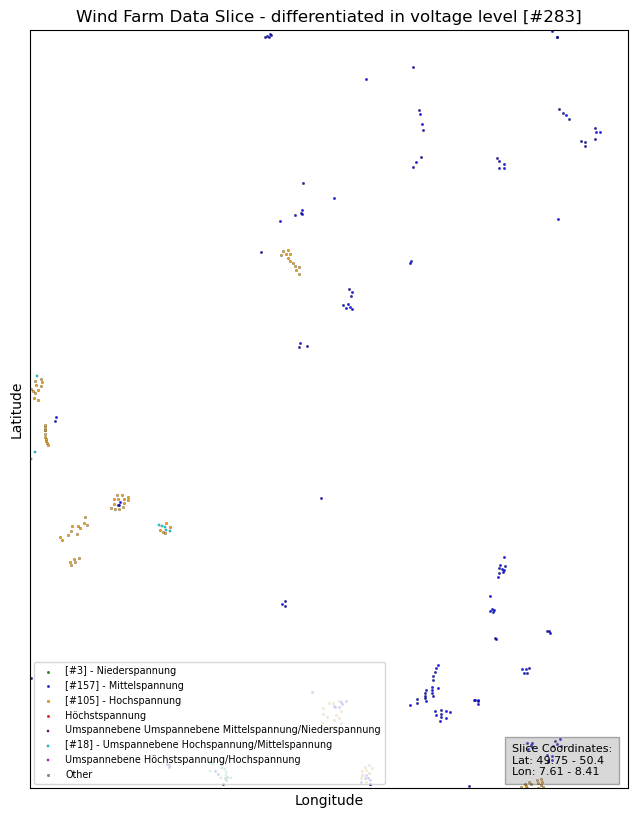

In [181]:
# RUN PLOT FUNCTION
if RUN_MULTI_PLOT:
    for i in range(MULTI_PLOT_COUNT):
        data_count_check = False
        iteration_count = 0
        # Slice Data for data count - check if data slice is big enough
        while not data_count_check:
            lat_min, lat_max, lon_min, lon_max = generate_slice_coordinates()
            print(f"Coordinates: Lat: {lat_min} - {lat_max} | Lon: {lon_min} - {lon_max}")
            slice_df = wind_ms_df[(wind_ms_df['longitude'] >= lon_min) & (wind_ms_df['longitude'] <= lon_max) & 
                    (wind_ms_df['latitude'] >= lat_min) & (wind_ms_df['latitude'] <= lat_max)]
            if slice_df.shape[0] > 30:
                data_count_check = True
                print("data slice shape:", slice_df.shape[0])
                print()
                iteration_count = 0
            else:
                print("data slice shape:", slice_df.shape[0])
                iteration_count += 1
                print(f"iteration count: {iteration_count}")

        data_count_check = False

        print("finished while loop - start plotting function...")

        # RUN PLOT FUNCTION
        data_plot_ULevel(wind_ms_df, lat_min, lat_max, lon_min, lon_max)
        clear_output(wait=True)
else:
    # Default values for slicing data
    data_plot_ULevel(wind_ms_df, lat_min, lat_max, lon_min, lon_max)

## Plot Umspannebene vs normal V-Level

In [182]:
count = wind_ms_df[wind_ms_df['Spannungsebene_Category'].str.contains("Umspannebene")].shape[0]
count


4411

In [183]:
wind_ms_df.columns

Index(['Betriebs-Status', 'Energieträger', 'Gemeindeschlüssel',
       'Nettonennleistung der Einheit', 'Bruttoleistung der Einheit',
       'Inbetriebnahmedatum der Einheit', 'Registrierungsdatum der Einheit',
       'Bundesland', 'latitude', 'longitude', 'Name des Windparks',
       'Letzte Aktualisierung', 'Name des Anlagenbetreibers (nur Org.)',
       'Name des Anschluss-Netzbetreibers',
       'MaStR-Nr. des Anschluss-Netzbetreibers', 'Spannungsebene',
       'Inbetriebnahmedatum der EEG-Anlage', 'Spannungsebene_Category'],
      dtype='object')

## 2. Cluster Data

In [184]:
# from sklearn.cluster import KMeans

# # Select the longitude and latitude columns
# coordinates = wind_df[['longitude', 'latitude']]

# # Define the number of clusters
# n_clusters = 10

# # Create an instance of the KMeans class
# kmeans = KMeans(n_clusters=n_clusters)

# # Fit the data to the model
# kmeans.fit(coordinates)

# # Get the cluster labels for each data point
# cluster_labels = kmeans.labels_

# # Add the cluster labels to the wind_df dataset
# wind_df['cluster_label'] = cluster_labels


### Evaluation Score Function

In [185]:
from sklearn.metrics import silhouette_score, calinski_harabasz_score, davies_bouldin_score
from pathlib import Path

In [186]:

def cluster_evaluation(data, labels, model_name, noise_count, eps_rad=0, min_samples_cluster=0):

    # Evaluate cluster quality
    s_score = silhouette_score(data, labels)
    ch_score = calinski_harabasz_score(data, labels)
    dbi_score = davies_bouldin_score(data, labels)

    # Prepare data for CSV
    eval_data = {"Model Name": model_name, 
                "eps_rad": eps_rad,
                "min_samples_cluster": min_samples_cluster,
                "Silhouette Score": round(s_score, 4),
                "Calinski-Harabasz Score": round(ch_score, 4),
                "Davies-Bouldin Score": round(dbi_score, 4),
                "Number of Clusters": len(set(labels)),
                "Noise Count": noise_count,
                "Data Points": data.shape[0]}

    if os.path.exists(EVALUATION_PATH):
        print("The file exists.")
        eval_df = pd.read_csv(EVALUATION_PATH)
    else:
        eval_df = pd.DataFrame(columns=["Model Name",
                                        "eps_rad",
                                        "min_samples_cluster",
                                        "Silhouette Score",
                                        "Calinski-Harabasz Score",
                                        "Davies-Bouldin Score",
                                        "Number of Clusters", 
                                        "Noise Count",
                                        "Data Points"])

    eval_df = eval_df.append(eval_data, ignore_index=True)

    eval_df.to_csv(EVALUATION_PATH, index=False)

    log_string(f"### {model_name} Model ###")
    if model_name == "DBSCAN":
        log_string(f"min sample per cluster: {min_samples_cluster}")
        log_string(f"eps: {eps_rad}")
    log_string(f"Silhouette Score: {s_score}")
    log_string(f"Calinski-Harabasz Score: {ch_score}")
    log_string(f"Davies-Bouldin Score: {dbi_score}")
    log_string(f"Number of clusters: {len(set(labels))}")
    log_string(f"Noise/Data: {noise_count}/{data.shape[0]}")

    print(f"Evaluating the model - {model_name}")
    print(f"Davies-Bouldin Index: {dbi_score:.4f}")
    print(f"Calinski-Harabasz Score: {ch_score:.4f}")
    print(f"Silhouette Score: {s_score:.4f}")
    print(f"Data saved to: {EVALUATION_PATH}")




### Dynamically calculation of eps distance for DBSCAN

In [187]:
from sklearn.neighbors import NearestNeighbors

def estimate_eps(df, k=5):
    """
    Estimate the optimal value for the eps parameter in DBSCAN
    """

    # Convert latitude and longitude to radians and then to matrix
    coords = np.radians(df[['latitude', 'longitude']].to_numpy())

    # Use NearestNeighbors to find the distance to the kth nearest neighbor
    nn = NearestNeighbors(n_neighbors=k)
    nn.fit(coords)
    distances, indices = nn.kneighbors(coords)

    # Take the distance to the k-th nearest neighbor as the local density estimate
    # FIXME: does not work like that
    kth_distances = distances[:, k-1] * 4

    # Use the median of the distance as a base for eps
    eps = np.median(kth_distances)

    return eps


### DBSCAN - Density-Based Spatial Clustering of Applications with Noise

In [188]:
from sklearn.cluster import DBSCAN # Density-Based Spatial Clustering of Applications with Noise

def dbscan_cluster(df, cluster_radius_km, k_neighbors, min_samples_cluster):
    # Earth's radius in kilometers
    EARTH_RADIUS = 6371

    # Set the parameters for DBSCAN
    # eps is the maximum distance (in kilometers)
    # min_samples is the minimum number of points to form a dense region
    
    if DYNAMIC_ESTIMATE_EPS:        
        # Calculate the dynamic eps value
        eps_rad = estimate_eps(df, k_neighbors) / EARTH_RADIUS # Convert eps to radians for use in haversine metric
        print(f"Dynamically estimated eps: {eps_rad}")
    else:
        eps_rad = cluster_radius_km / EARTH_RADIUS # Convert eps to radians for use in haversine metric
        print(f"Fixed eps: {eps_rad}")

    # Convert latitude and longitude to radians and then to a matrix
    coords = df[['latitude', 'longitude']].to_numpy()
    coords = np.radians(coords)

    db_model = DBSCAN(eps=eps_rad, min_samples=min_samples_cluster, algorithm='ball_tree', metric='haversine')
    df['cluster'] = db_model.fit_predict(coords)

    noise_count = df[df["cluster"] == -1].shape[0]

    cluster_evaluation(coords, db_model.labels_, "DBSCAN", noise_count, cluster_radius_km, min_samples_cluster)

    return df


### HDBSCAN - Cluster Algorithm
HDBSCAN is an extension of DBSCAN that improves upon its scalability and ability to handle varying density clusters. It automatically determines the eps parameter and can merge clusters of varying densities.

In [189]:
null_name_count = wind_ms_df[wind_ms_df['Name des Windparks'].isnull()].shape[0]
print(f"Number of rows with no value in 'Name des Windparks' column: {null_name_count}/{wind_ms_df.shape[0]}")

Number of rows with no value in 'Name des Windparks' column: 619/30396


In [190]:
# TEMP_KEEP_COLS = ['latitude', 'longitude', 'Name des Windparks', 'Name des Anschluss-Netzbetreibers']

# def prepare_df_for_clustering(df):
#     # Remove original non-numerical columns
#     df = df.drop(columns=TEMP_KEEP_COLS)

#     # Hot-encode non-numerical columns
#     df_encoded = pd.get_dummies(df[TEMP_KEEP_COLS])
    
#     return df_encoded


In [191]:
import hdbscan
from sklearn.preprocessing import StandardScaler, OneHotEncoder

def hdbscan_cluster(df, cluster_radius_km, min_samples_cluster):
    # Preprocess the data: One-hot encode operator names and standardize features
    operator_encoder = OneHotEncoder(sparse_output=False)  # Specify dense output for compatibility
    operator_encoded = operator_encoder.fit_transform(df[['Name des Anlagenbetreibers (nur Org.)']])

    # Preprocess the data: Standardize features by removing the mean and scaling to unit variance
    scaler = StandardScaler()
    wind_ms_df_scaled = scaler.fit_transform(df[['latitude', 'longitude']])

    # Combine and normalize encoded and scaled features
    combined_features = np.concatenate([wind_ms_df_scaled, operator_encoded], axis=1)
    normalized_features = scaler.fit_transform(combined_features)

    # Initialize HDBSCAN
    hdb_model = hdbscan.HDBSCAN(min_cluster_size=min_samples_cluster, metric='euclidean', cluster_selection_method='eom')

    # Fit the model
    # clusterer.fit(normalized_features)
    hdb_model.fit(wind_ms_df_scaled)

    # Assign the cluster labels to your dataframe
    df['cluster'] = hdb_model.labels_

    noise_count = df[df['cluster'] == -1].shape[0]

    cluster_evaluation(wind_ms_df_scaled, hdb_model.labels_, "HDBSCAN", noise_count, cluster_radius_km, min_samples_cluster=min_samples_cluster)

    return df

### Select Cluster Algorithm logic

In [192]:
wind_ms_df.shape

(30396, 18)

In [193]:

# Decision function like switch case
def run_cluster_algorith(temp_df, cluster_algorithm_decision, eps_val, min_samples):
    if cluster_algorithm_decision.lower() == "dbscan":

        clustered_wind_df = dbscan_cluster(temp_df, cluster_radius_km=eps_val, k_neighbors=K_NEIGHBORS, min_samples_cluster=min_samples)

    elif cluster_algorithm_decision.lower() == "hdbscan":
        clustered_wind_df = hdbscan_cluster(temp_df, cluster_radius_km=eps_val, min_samples_cluster=min_samples)
        
    else:
        print("No valid cluster algorithm decision")
        return None
    
    return clustered_wind_df


# # CLUSTER_ALGO_DECISION = "dbscan"
# CLUSTER_ALGO_DECISION = "hdbscan"

# CLUSTER_RADIUS_KM = 0.25
# MIN_SAMPLES = 2
# K_NEIGHBORS = 5

# clustered_wind_ms_df = run_cluster_algorith(wind_ms_df, CLUSTER_ALGO_DECISION)

### Example slice and plot of manually choosen cluster

In [194]:
# filtered_df_test = clustered_wind_ms_df[(abs(clustered_wind_ms_df['latitude'] - 53.7137) < 0.01) & (abs(clustered_wind_ms_df['longitude'] - 13.3284) < 0.01)]
# filtered_df_test.head()

In [195]:
# # clustered_wind_ms_df.head(30)
# filtered_df0 = clustered_wind_ms_df[clustered_wind_ms_df['cluster'] == 442]
# filtered_df1 = clustered_wind_ms_df[clustered_wind_ms_df['cluster'] == 443]
# filtered_df2 = clustered_wind_ms_df[clustered_wind_ms_df['cluster'] == 444]
# filtered_df3 = clustered_wind_ms_df[clustered_wind_ms_df['cluster'] == 445]
# plot_data = [filtered_df0, filtered_df1, filtered_df2, filtered_df3]

# for data in plot_data:
#     cluster_name = data['cluster'].unique()[0]
#     plt.scatter(data['longitude'], data['latitude'], label=f"Cluster {cluster_name} [#{data.shape[0]}]", s=8)

# plt.xlabel('Longitude')
# plt.ylabel('Latitude')
# plt.title('Longitude vs Latitude')
# plt.legend()
# plt.show()



In [196]:
# for data in plot_data:
#     for index, row in data.iterrows():
#         print(f"Latitude: {row['latitude']}, Longitude: {row['longitude']}, Cluster: {row['cluster']}")

## 3. Plot Cluster Data

In [197]:
import random

# Function to generate a random color in hexadecimal format
def get_random_color():
    return "#{:06x}".format(random.randint(0, 0xFFFFFF))

In [198]:
def calculate_marker_size(cluster_count, min_count, max_count):
    # Define the minimum and maximum marker sizes
    min_size = 5
    max_size = 30

    # Calculate the marker size based on the cluster count
    marker_size = min_size + ((cluster_count - min_count) / (max_count - min_count)) * (max_size - min_size)

    return marker_size

In [199]:
# # Extract the cluster labels
# # labels = db.labels_
# labels = data.cluster.unique()

# # Get unique cluster labels
# unique_labels = np.unique(labels)

# # Create a colormap for the clusters
# colors = plt.cm.Spectral(np.linspace(0, 1, len(unique_labels)))

### Plot Cluster Data

In [200]:
import matplotlib.pyplot as plt
from scipy.spatial import ConvexHull


def plot_cluster(data, model_name, cluster_radius, min_samples, lon_max, lon_min, lat_max, lat_min):
    # Turn the date column into a datetime object
    data['Inbetriebnahmedatum der Einheit'] = pd.to_datetime(data['Inbetriebnahmedatum der Einheit'], format='%d/%m/%Y')

    # TODO: use threshold dates to plot each cluster devided in "Inbetriebnahme Datum"
    threshold_date_str = ["01/01/2013", "01/01/2016", "01/01/2017", "01/01/2020"]
    threshold_dates = [pd.to_datetime(date) for date in threshold_date_str]

    # Convert latitude and longitude to radians and then to a matrix
    coords = data[['latitude', 'longitude']].to_numpy()
    coords_radiant = np.radians(coords)

    eps_km = cluster_radius 

    # Extract the cluster labels
    # labels = db.labels_
    labels = data.cluster.unique()

    # Get unique cluster labels
    unique_labels = np.unique(labels)

    # Create a colormap for the clusters
    colors = plt.cm.Spectral(np.linspace(0, 1, len(unique_labels)))

    # Plot Variables
    image_width_to_height_ratio = (lon_max - lon_min) / (lat_max - lat_min)

    # fig, ax = plt.subplots()
    fig, ax = plt.subplots(figsize=(8, 8 * image_width_to_height_ratio))

    # Create a Basemap instance that aligns with Google Maps projection and bounds
    m = Basemap(projection='merc', llcrnrlat=lat_min, urcrnrlat=lat_max,
                llcrnrlon=lon_min, urcrnrlon=lon_max, lat_ts=20, resolution='i', ax=ax)

    m.drawcoastlines()
    m.drawcountries()

    markers = ['o', 'v', '^', '<', '>', '8', 's', 'p', '*', 'h']
    # df_thresholds = []
    # for i in range(len(threshold_dates) - 1):
    #     start_date = threshold_dates[i]
    #     end_date = threshold_dates[i + 1]
    #     df_slice = data[data['Inbetriebnamedatum der Einheit'].between(start_date, end_date)]
    #     df_thresholds.append(df_slice)
    df_th_1 = data[data['Inbetriebnahmedatum der Einheit'] < threshold_dates[0]]
    df_th_2 = data[(data['Inbetriebnahmedatum der Einheit'] >= threshold_dates[0]) & (data['Inbetriebnahmedatum der Einheit'] < threshold_dates[1])]
    df_th_3 = data[(data['Inbetriebnahmedatum der Einheit'] >= threshold_dates[1]) & (data['Inbetriebnahmedatum der Einheit'] < threshold_dates[2])]
    df_th_4 = data[(data['Inbetriebnahmedatum der Einheit'] >= threshold_dates[2]) & (data['Inbetriebnahmedatum der Einheit'] < threshold_dates[3])]
    df_th_5 = data[data['Inbetriebnahmedatum der Einheit'] >= threshold_dates[3]]
    df_thresholds = [df_th_1, df_th_2, df_th_3, df_th_4, df_th_5]

    scatter_legends = []
    color_cache = {}

    if SLICE_DATA:
        temp_marker_size = 1
    else:
        temp_marker_size = 0.1

    # Plot labels for each cluster
    # First print out count for each cluster and define colour
    unique_cluster = data['cluster'].unique()
    print(f"Algorithm found: {len(unique_cluster)} cluster with {data.shape[0]} data points.")
    for index, cluster in enumerate(unique_cluster):
        # Get the number of data points in the cluster
        cluster_count = data[data['cluster'] == cluster].shape[0]

        # threshold_date_marker = markers[index]
        print(f"Cluster: {cluster} [#{cluster_count}]")

        # Generate a random color
        
        if cluster == -1:
            print(f"Cluster -1 => noise [#{cluster_count}]")
            color_cache[cluster] = "grey"
        else:
            random_color = get_random_color()
            color_cache[cluster] = random_color

        if SLICE_DATA:
            # Get mean coordinates for the cluster to place the label
            temp_cluster_df = data[data['cluster'] == cluster]
            mean_x = temp_cluster_df['longitude'].mean()
            mean_y = temp_cluster_df['latitude'].mean()
            x_cluster_label, y_cluster_label = m(mean_x, mean_y)

        
            # Plot the label
            temp_cluster_label = f"{cluster}"
            cluster_label_font_size = 5
            plt.annotate(temp_cluster_label, (x_cluster_label, y_cluster_label), xytext=(5, -5), textcoords='offset points', fontsize=cluster_label_font_size)

        first_row = data.loc[data['cluster'] == cluster].iloc[0]
        # Convert lat/lon to map projection coordinates
        x, y = m(first_row.longitude, first_row.latitude)
        temp_cluster_legend = f"Cluster {cluster}"
        # temp_scatter_legend = m.scatter(x, y, color=color_cache[cluster], marker=threshold_date_marker, s=2, edgecolors='black', linewidth=0.1, label=temp_cluster_legend)
        temp_scatter_legend = m.scatter(x, y, color=color_cache[cluster], s=temp_marker_size, edgecolors='black', linewidth=0.01, label=temp_cluster_legend)
        scatter_legends.append(temp_scatter_legend)


    # Plot the clusters
    for index, df_slice in enumerate(df_thresholds):
        threshold_date_marker = markers[index]
        unique_cluster = np.unique(df_slice['cluster'])

        for cluster in unique_cluster:
            if cluster == -1:
                if SLICE_DATA:
                    marker_size = 1
                else: 
                    marker_size = 0.05
            else:
                if SLICE_DATA:
                    marker_size = 3
                else:
                    marker_size = 0.1

            # Get the indices for each cluster label
            indices = np.where(labels == cluster)
            # Create a dataframe for each cluster
            # cluster_df = df_slice.iloc[indices]
            cluster_df = df_slice[df_slice['cluster'] == cluster]

            # temp_marker_color = get_random_color()

            # Get marker color
            temp_marker_color = color_cache[cluster]

            # Convert lat/lon to map projection coordinates
            x, y = m(cluster_df.longitude, cluster_df.latitude)

            # Define label
            temp_label = f"Cluster {cluster} [#{cluster_df.shape[0]}]"

            # Plot the clusters
            temp_scatter = m.scatter(x, y, color=temp_marker_color, marker=threshold_date_marker, s=marker_size, edgecolors='black', linewidth=0.01, label="temp_label")
            # temp_label_scatter = m.sc
            # scatter_legends.append(temp_scatter)

            # Add text to each point in the scatter plot
            # for i, txt in enumerate(cluster_df['Inbetriebnahmedatum der Einheit']):
            multiline_string = "\n".join(threshold_date_str)

            # ax.text(10, 2, multiline_string, fontsize=8)


    # Setting labels and title
    ax.set_xlabel('Longitude')
    ax.set_ylabel('Latitude')
    ax.set_title(f'Wind Farm Data clustered - {model_name}, eps_km={eps_km}km, min_samp={min_samples} - [#{data.shape[0]}]')
    ax.grid(True)
    # ax.legend(handles=scatter_legends, fontsize="xx-small", loc='lower left')

    plot_id = str(uuid.uuid4())
    plt.savefig(PLOT_SAVE_PATH + f"windpark_cluster_plot_{model_name}_{eps_km}km_{min_samples}_minSamp_{plot_id}.png", dpi=1500, bbox_inches='tight')

    # clear_output(wait=True)

    plt.show()


# len(clustered_wind_ms_df.cluster.unique())
# plot_cluster(clustered_wind_ms_df, CLUSTER_ALGO_DECISION, CLUSTER_RADIUS_KM, MIN_SAMPLES)
# clustered_wind_ms_df.columns

## 4. Data Clustering and Evaluation

### Cluster runs with different eps and min_sample variables
### Plots for visual evaluation  
DBSCAN and HDBSCAN with:
1. eps -> 0.25, 0.35, 0.45, 0.55, 0.65, 0.75
2. min_samples with best performing eps -> 2, 3, 4, 5, 6, 7

In [201]:
RUN_MULTI_EVALUATION = False
RUN_MULTI_DETAIL_PLOTS = False # only for more detailed investigations of a list of given coordinates for slicing

The file exists.
Evaluating the model - HDBSCAN
Davies-Bouldin Index: 1.4315
Calinski-Harabasz Score: 205.6981
Silhouette Score: 0.6165
Data saved to: /Users/andreaszwikirsch/Desktop/01Uni/03BA_WS22/python_scripts/windpark_clustering/data_store/cluster_eval.csv


/var/folders/9r/_jvgz_s166ddc8pfjh0ck_080000gn/T/ipykernel_7358/3235438652.py:33: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  eval_df = eval_df.append(eval_data, ignore_index=True)


Algorithm found: 2360 cluster with 30396 data points.
Cluster: 533 [#40]
Cluster: 2292 [#4]
Cluster: 2152 [#17]
Cluster: 313 [#4]
Cluster: 2341 [#8]
Cluster: 119 [#7]
Cluster: 1310 [#32]
Cluster: 2155 [#11]
Cluster: 1993 [#5]
Cluster: 87 [#75]
Cluster: 532 [#27]
Cluster: 1397 [#7]
Cluster: 1628 [#10]
Cluster: 2260 [#9]
Cluster: 1606 [#12]
Cluster: 603 [#6]
Cluster: 1787 [#16]
Cluster: 2271 [#4]
Cluster: -1 [#1723]
Cluster -1 => noise [#1723]
Cluster: 821 [#11]
Cluster: 2101 [#8]
Cluster: 1340 [#17]
Cluster: 583 [#33]
Cluster: 2351 [#14]
Cluster: 1017 [#5]
Cluster: 770 [#17]
Cluster: 884 [#9]
Cluster: 781 [#7]
Cluster: 1312 [#7]
Cluster: 1881 [#6]
Cluster: 2012 [#22]
Cluster: 1597 [#13]
Cluster: 1906 [#4]
Cluster: 607 [#51]
Cluster: 453 [#6]
Cluster: 1653 [#45]
Cluster: 1657 [#9]
Cluster: 1339 [#8]
Cluster: 1900 [#25]
Cluster: 950 [#7]
Cluster: 976 [#35]
Cluster: 846 [#16]
Cluster: 587 [#44]
Cluster: 1751 [#6]
Cluster: 1827 [#18]
Cluster: 537 [#30]
Cluster: 1764 [#6]
Cluster: 1058 [#5]


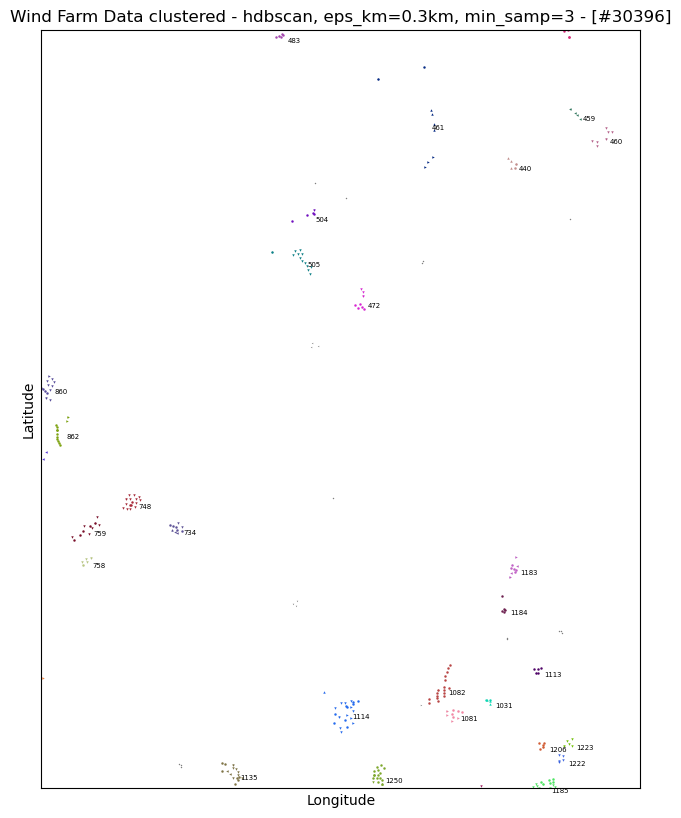

In [202]:
if RUN_MULTI_EVALUATION:
    K_NEIGHBORS = 5
    eps_list = [0.25, 0.35, 0.45, 0.55, 0.65, 0.75]
    min_samples_list = [2, 3, 4, 5, 6, 7]
    cluster_algo_options = ["dbscan", "hdbscan"]

    # RUN CLUSTER ALGORITHM EVALUATION LOOP -> runs ~11min
    for temp_eps_val in eps_list:
        CLUSTER_RADIUS_KM = temp_eps_val

        for temp_min_sample in min_samples_list:
            MIN_SAMPLES = temp_min_sample

            for temp_model_option in cluster_algo_options:
                CLUSTER_ALGO_DECISION = temp_model_option

                print(f"eps = {CLUSTER_RADIUS_KM}, min_samples = {MIN_SAMPLES}, model = {CLUSTER_ALGO_DECISION}")

                print(f"Run {temp_model_option} Algorithm with {temp_eps_val} and {temp_min_sample}")

                clustered_wind_df = run_cluster_algorith(wind_ms_df, temp_model_option, temp_eps_val, temp_min_sample)

                print("Finished clustering")

                print(f"Clustered {clustered_wind_df.shape[0]} data points in {len(clustered_wind_df.cluster.unique())} cluster \nwith {temp_eps_val}km radius and {temp_min_sample} min samples")
                print("Cluser labels:", clustered_wind_df.cluster.unique())
                print(f"Cluster noise: {clustered_wind_df[clustered_wind_df.cluster == -1].shape[0]}/{clustered_wind_df.shape[0]}")

                # Plot the clusters -> for visual evaluation
                print("Plot the clusters...")
                
                # RUN PLOT FUNCTION
                plot_cluster(clustered_wind_df, CLUSTER_ALGO_DECISION, CLUSTER_RADIUS_KM, MIN_SAMPLES, lon_max, lon_min, lat_max, lat_min)
                
                print("Finished plotting \n")
            
            clear_output(wait=True)

        clear_output(wait=True)

    # Update global variables for nameing of plots and files
    CLUSTER_ALGO_DECISION = temp_model_option
    CLUSTER_RADIUS_KM = temp_eps_val
    MIN_SAMPLES = temp_min_sample
    # K_NEIGHBORS = K_NEIGHBORS
    

else:
    # CLUSTER_ALGO_DECISION = "dbscan"
    CLUSTER_ALGO_DECISION = "hdbscan"
    CLUSTER_RADIUS_KM = 0.3
    MIN_SAMPLES = 3
    K_NEIGHBORS = 5

    if RUN_MULTI_DETAIL_PLOTS and SLICE_DATA:
        # [[lat_min, lat_max, lon_min, lon_max]]
        slice_coordinates = [[50.52, 51.17, 10.36, 11.16],
                            [52.02, 52.67, 14.17, 14.97],
                            [52.7, 53.35, 13.57, 14.37],
                            [52.1, 52.75, 12.24, 13.04]]

        clustered_wind_df = run_cluster_algorith(wind_ms_df, CLUSTER_ALGO_DECISION, CLUSTER_RADIUS_KM, MIN_SAMPLES)

        for coordinates in slice_coordinates:
            lat_min, lat_max, lon_min, lon_max = coordinates
            print(f"Coordinates: Lat: {lat_min} - {lat_max} | Lon: {lon_min} - {lon_max}")
            # Plot the clusters -> for visual evaluation
            plot_cluster(clustered_wind_df, CLUSTER_ALGO_DECISION, CLUSTER_RADIUS_KM, MIN_SAMPLES, lon_max, lon_min, lat_max, lat_min)
            clear_output(wait=True)


    else:
        # CLUSTER_ALGO_DECISION = "dbscan"
        # CLUSTER_ALGO_DECISION = "hdbscan"

        # CLUSTER_RADIUS_KM = 0.3
        # MIN_SAMPLES = 3
        # K_NEIGHBORS = 5

        clustered_wind_df = run_cluster_algorith(wind_ms_df, CLUSTER_ALGO_DECISION, CLUSTER_RADIUS_KM, MIN_SAMPLES)
        # clustered_wind_df = run_cluster_algorith(wind_ms_df, CLUSTER_ALGO_DECISION)

        # Plot the clusters -> for visual evaluation
        plot_cluster(clustered_wind_df, CLUSTER_ALGO_DECISION, CLUSTER_RADIUS_KM, MIN_SAMPLES, lon_max, lon_min, lat_max, lat_min)

### Detailed cluster plot and investigation

In [203]:
detail_df = wind_ms_df[wind_ms_df['cluster'] == 606]
detail_df.to_csv(SUB_DATA_PATH + "detail_data_606.csv", index=False)

detail_df.shape

(25, 19)

/var/folders/9r/_jvgz_s166ddc8pfjh0ck_080000gn/T/ipykernel_7358/234374831.py:19: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df['Spannungsebene_Category'] = df['Spannungsebene'].apply(categorize_spannungsebene)


/var/folders/9r/_jvgz_s166ddc8pfjh0ck_080000gn/T/ipykernel_7358/234374831.py:111: UserWarning: The label '_child4' of <matplotlib.collections.PathCollection object at 0x323a4fd60> starts with '_'. It is thus excluded from the legend.
  ax.legend(handles=scatter_legends, fontsize="x-small", loc='lower left')
/var/folders/9r/_jvgz_s166ddc8pfjh0ck_080000gn/T/ipykernel_7358/234374831.py:111: UserWarning: The label '_child6' of <matplotlib.collections.PathCollection object at 0x32546e3e0> starts with '_'. It is thus excluded from the legend.
  ax.legend(handles=scatter_legends, fontsize="x-small", loc='lower left')
/var/folders/9r/_jvgz_s166ddc8pfjh0ck_080000gn/T/ipykernel_7358/234374831.py:111: UserWarning: The label '_child8' of <matplotlib.collections.PathCollection object at 0x32546cc70> starts with '_'. It is thus excluded from the legend.
  ax.legend(handles=scatter_legends, fontsize="x-small", loc='lower left')
/var/folders/9r/_jvgz_s166ddc8pfjh0ck_080000gn/T/ipykernel_7358/234374831

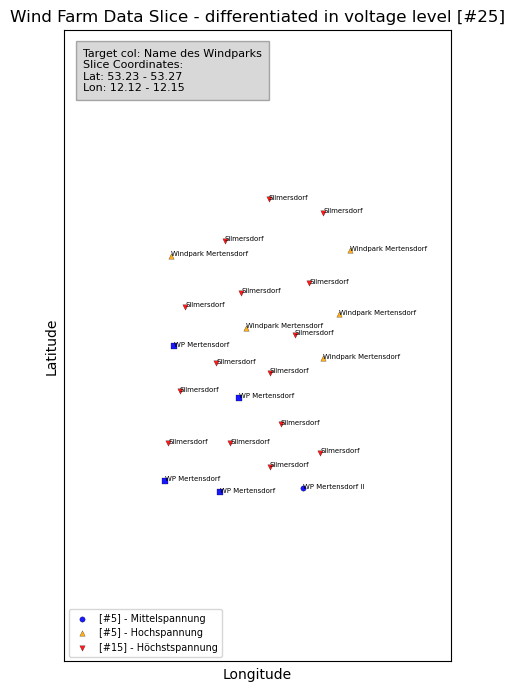

In [204]:
operator_marker_map = ['o', 's', '^', 'v', '<', '>', 'p', '*', 'h', 'H', '+', 'x', 'D', 'd', '|', '_']

def detail_data_plot_ULevel(df, lat_min, lat_max, lon_min, lon_max):
    # # Function to categorize Spannungsebene
    # @cache
    # def categorize_spannungsebene(row):
    #     if 'Niederspannung' in row:
    #         return 'Niederspannung'
    #     elif 'Mittelspannung' in row:
    #         return 'Mittelspannung'
    #     elif 'Hochspannung' in row:
    #         return 'Hochspannung'
    #     elif 'Höchstspannung' in row:
    #         return 'Höchstspannung'
    #     else:
    #         return 'Other'

    # Apply the function to create a new column
    df['Spannungsebene_Category'] = df['Spannungsebene'].apply(categorize_spannungsebene)

    # Slice Data for data count
    if SLICE_DATA:
        df = df[(df['longitude'] >= lon_min) & (df['longitude'] <= lon_max) & 
                    (df['latitude'] >= lat_min) & (df['latitude'] <= lat_max)]

    # Define color mapping
    color_map = {
        'Niederspannung': 'green',
        'Mittelspannung': 'blue',
        'Hochspannung': 'orange',
        'Höchstspannung': 'red',
        'Other': 'gray'  # For any category that doesn't match the specified ones
    }

    # Calculate aspect ratio
    image_width_to_height_ratio = (lon_max - lon_min) / (lat_max - lat_min)

    # Create a figure with the same aspect ratio
    fig, ax = plt.subplots(figsize=(8, 8 * image_width_to_height_ratio))

    # Set the background color as transparent
    # fig.patch.set_alpha(0)
    # ax.patch.set_alpha(0)

    # Create a Basemap instance that aligns with Google Maps projection and bounds
    m = Basemap(projection='merc', llcrnrlat=lat_min, urcrnrlat=lat_max,
                llcrnrlon=lon_min, urcrnrlon=lon_max, lat_ts=20, resolution='i', ax=ax)

    m.drawcoastlines()
    m.drawcountries()

    # Convert lat/long to map projection coordinates
    x, y = m(df.longitude, df.latitude)

    if df.shape[0] < 50:
        maker_size = 15
    else:
        maker_size = 3

    # target_column_str = 'Name des Anlagenbetreibers (nur Org.)'
    # target_column_str = 'Name des Anschluss-Netzbetreibers'
    target_column_str = 'Name des Windparks'

    marker_category_list = {}
    scatter_legends = []
    for category, color in color_map.items():
        subset = df[df['Spannungsebene_Category'] == category]
        temp_label = f"[#{subset.shape[0]}] - {category}" if subset.shape[0] != 0 else f"{category}"

        # Iterate through each subset row to plot with the corresponding marker shape
        for index, row in subset.iterrows():

            target_value = row[target_column_str]
            
            if target_value not in marker_category_list:
                marker_category_list[target_value] = operator_marker_map.pop(0)
            # marker = operator_marker_map.get(operator_name, 'o')  # Default to circle if operator not in map
            
            x_temp, y_temp = m([row.longitude], [row.latitude])
            scatter = m.scatter(x_temp, y_temp, alpha=0.9, color=color, s=maker_size, 
                                label=temp_label if index == subset.first_valid_index() else "", 
                                edgecolors='black', linewidth=0.2, marker=marker_category_list[target_value])
            scatter_legends.append(scatter)

            plt.text(x_temp[0], y_temp[0], row[target_column_str].split("(")[0], fontsize=5)

            # To avoid duplicate labels in the legend, only add the scatter object once per category
            # if index == subset.first_valid_index():
            #     scatter_legends.append(scatter)

        # x_temp, y_temp = m(subset.longitude, subset.latitude)
        # scatter = m.scatter(x_temp, y_temp, alpha=0.9, color=color, s=maker_size, label=temp_label, edgecolors='black', linewidth=0.2)
        # scatter_legends.append(scatter)
    
    text_box_string = f"Target col: {target_column_str}\nSlice Coordinates:\nLat: {round(lat_min, 2)} - {round(lat_max, 2)}\nLon: {round(lon_min, 2)} - {round(lon_max, 2)}"

    # Add a text box
    # plt.text(0.805, 0.015, text_box_string, bbox=dict(facecolor='grey', alpha=0.3, pad=5), 
    #         horizontalalignment='left', verticalalignment='bottom', 
    #         transform=plt.gca().transAxes, fontsize=8)
    plt.text(0.05, 0.9, text_box_string, bbox=dict(facecolor='grey', alpha=0.3, pad=5), 
        horizontalalignment='left', verticalalignment='bottom', 
        transform=plt.gca().transAxes, fontsize=8)


    # Setting labels and title
    ax.set_xlabel('Longitude')
    ax.set_ylabel('Latitude')
    ax.set_title(f'Wind Farm Data Slice - differentiated in voltage level [#{df.shape[0]}]')
    ax.grid(True)
    ax.legend(handles=scatter_legends, fontsize="x-small", loc='lower left')

    plot_id = str(uuid.uuid4())
    # plt.savefig(plot_save_path + "wind_ms_all_data_plot.png", dpi=plot_save_resolution, bbox_inches='tight', transparent=True)
    plt.savefig(PLOT_SAVE_PATH + f"wind_ms_detail_data_plot_{target_column_str}_{plot_id}.png", dpi=PLOT_SAVE_RESOLUTION, bbox_inches='tight')
    
    plt.show()


# # RUN PLOT FUNCTION
# data_plot_ULevel(wind_ms_df, lat_min, lat_max, lon_min, lon_max)
detail_data_plot_ULevel(detail_df, detail_df.latitude.min()-0.01, detail_df.latitude.max()+0.01, detail_df.longitude.min()-0.01, detail_df.longitude.max()+0.01)

In [205]:
detail_df.columns

Index(['Betriebs-Status', 'Energieträger', 'Gemeindeschlüssel',
       'Nettonennleistung der Einheit', 'Bruttoleistung der Einheit',
       'Inbetriebnahmedatum der Einheit', 'Registrierungsdatum der Einheit',
       'Bundesland', 'latitude', 'longitude', 'Name des Windparks',
       'Letzte Aktualisierung', 'Name des Anlagenbetreibers (nur Org.)',
       'Name des Anschluss-Netzbetreibers',
       'MaStR-Nr. des Anschluss-Netzbetreibers', 'Spannungsebene',
       'Inbetriebnahmedatum der EEG-Anlage', 'Spannungsebene_Category',
       'cluster'],
      dtype='object')

In [206]:
print(detail_df["Name des Anschluss-Netzbetreibers"].unique())
print()
print(detail_df["Name des Anlagenbetreibers (nur Org.)"].unique())
print()
print(detail_df["Name des Windparks"].unique())

['50Hertz Transmission GmbH (SNB982046657236)'
 'E.DIS Netz GmbH (SNB941690671609)']

['Windpark Silmersdorf 1 GmbH & Co. KG'
 'Windpark Silmersdorf 2 GmbH & Co. KG'
 'Windpark Silmersdorf 3 GmbH & Co. KG'
 'Windpark Silmersdorf 4 GmbH & Co. KG'
 'Windpark Silmersdorf 10 GmbH & Co. KG'
 'GJS PrignitzWind III GmbH & Co. KG' 'GJS PrignitzWind GmbH & Co. KG'
 'GJS PrignitzWind II GmbH & Co. KG' 'Märkische Windkraft 80'
 'Norddeutsche Energie WP Silmersdorf GmbH & Co. KG']

['Silmersdorf' 'WP Mertensdorf II' 'WP Mertensdorf' 'Windpark Mertensdorf']


/var/folders/9r/_jvgz_s166ddc8pfjh0ck_080000gn/T/ipykernel_7358/234374831.py:19: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df['Spannungsebene_Category'] = df['Spannungsebene'].apply(categorize_spannungsebene)


/var/folders/9r/_jvgz_s166ddc8pfjh0ck_080000gn/T/ipykernel_7358/234374831.py:111: UserWarning: The label '_child4' of <matplotlib.collections.PathCollection object at 0x337873fa0> starts with '_'. It is thus excluded from the legend.
  ax.legend(handles=scatter_legends, fontsize="x-small", loc='lower left')
/var/folders/9r/_jvgz_s166ddc8pfjh0ck_080000gn/T/ipykernel_7358/234374831.py:111: UserWarning: The label '_child6' of <matplotlib.collections.PathCollection object at 0x337873f10> starts with '_'. It is thus excluded from the legend.
  ax.legend(handles=scatter_legends, fontsize="x-small", loc='lower left')
/var/folders/9r/_jvgz_s166ddc8pfjh0ck_080000gn/T/ipykernel_7358/234374831.py:111: UserWarning: The label '_child8' of <matplotlib.collections.PathCollection object at 0x3378a0c10> starts with '_'. It is thus excluded from the legend.
  ax.legend(handles=scatter_legends, fontsize="x-small", loc='lower left')
/var/folders/9r/_jvgz_s166ddc8pfjh0ck_080000gn/T/ipykernel_7358/234374831

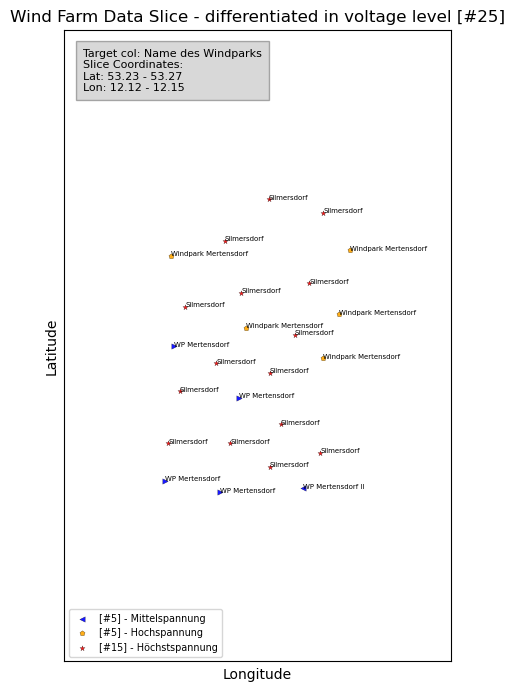

In [207]:
detail_data_plot_ULevel(detail_df, detail_df.latitude.min()-0.01, detail_df.latitude.max()+0.01, detail_df.longitude.min()-0.01, detail_df.longitude.max()+0.01)

In [208]:
detail_df.columns

Index(['Betriebs-Status', 'Energieträger', 'Gemeindeschlüssel',
       'Nettonennleistung der Einheit', 'Bruttoleistung der Einheit',
       'Inbetriebnahmedatum der Einheit', 'Registrierungsdatum der Einheit',
       'Bundesland', 'latitude', 'longitude', 'Name des Windparks',
       'Letzte Aktualisierung', 'Name des Anlagenbetreibers (nur Org.)',
       'Name des Anschluss-Netzbetreibers',
       'MaStR-Nr. des Anschluss-Netzbetreibers', 'Spannungsebene',
       'Inbetriebnahmedatum der EEG-Anlage', 'Spannungsebene_Category',
       'cluster'],
      dtype='object')

In [209]:
print("Name des Anlagenbetreibers (nur Org.):")
print(detail_df["Name des Anlagenbetreibers (nur Org.)"].unique())
print()
print("Name des Anschluss-Netzbetreibers:")
print(detail_df["Name des Anschluss-Netzbetreibers"].unique())

Name des Anlagenbetreibers (nur Org.):
['Windpark Silmersdorf 1 GmbH & Co. KG'
 'Windpark Silmersdorf 2 GmbH & Co. KG'
 'Windpark Silmersdorf 3 GmbH & Co. KG'
 'Windpark Silmersdorf 4 GmbH & Co. KG'
 'Windpark Silmersdorf 10 GmbH & Co. KG'
 'GJS PrignitzWind III GmbH & Co. KG' 'GJS PrignitzWind GmbH & Co. KG'
 'GJS PrignitzWind II GmbH & Co. KG' 'Märkische Windkraft 80'
 'Norddeutsche Energie WP Silmersdorf GmbH & Co. KG']

Name des Anschluss-Netzbetreibers:
['50Hertz Transmission GmbH (SNB982046657236)'
 'E.DIS Netz GmbH (SNB941690671609)']


### Plot Cluster based on "Name des Anlagenbetreibers (nur Org.) or "Name des Anschluss-Netzbetreibers"

In [210]:
clustered_wind_df.columns

Index(['Betriebs-Status', 'Energieträger', 'Gemeindeschlüssel',
       'Nettonennleistung der Einheit', 'Bruttoleistung der Einheit',
       'Inbetriebnahmedatum der Einheit', 'Registrierungsdatum der Einheit',
       'Bundesland', 'latitude', 'longitude', 'Name des Windparks',
       'Letzte Aktualisierung', 'Name des Anlagenbetreibers (nur Org.)',
       'Name des Anschluss-Netzbetreibers',
       'MaStR-Nr. des Anschluss-Netzbetreibers', 'Spannungsebene',
       'Inbetriebnahmedatum der EEG-Anlage', 'Spannungsebene_Category',
       'cluster'],
      dtype='object')

In [211]:
print(len(clustered_wind_df['Name des Anlagenbetreibers (nur Org.)'].unique()))
clustered_wind_df['Name des Anlagenbetreibers (nur Org.)'].unique()

9418


array(['Windfeld Bütow/Zepkow GmbH & Co. 1. Betreiber KG',
       'GBO Erler Windenergie GmbH & Co. KG',
       'Windenergie Gut Geilern GbR', ...,
       'natürliche Person (ABR959005411994)',
       'natürliche Person (ABR976544900680)',
       'Nüsser Ingenieurges.mbH für Energie- und Umwelttechnik'],
      dtype=object)

Algorithm found: 9418 cluster with 30396 data points.


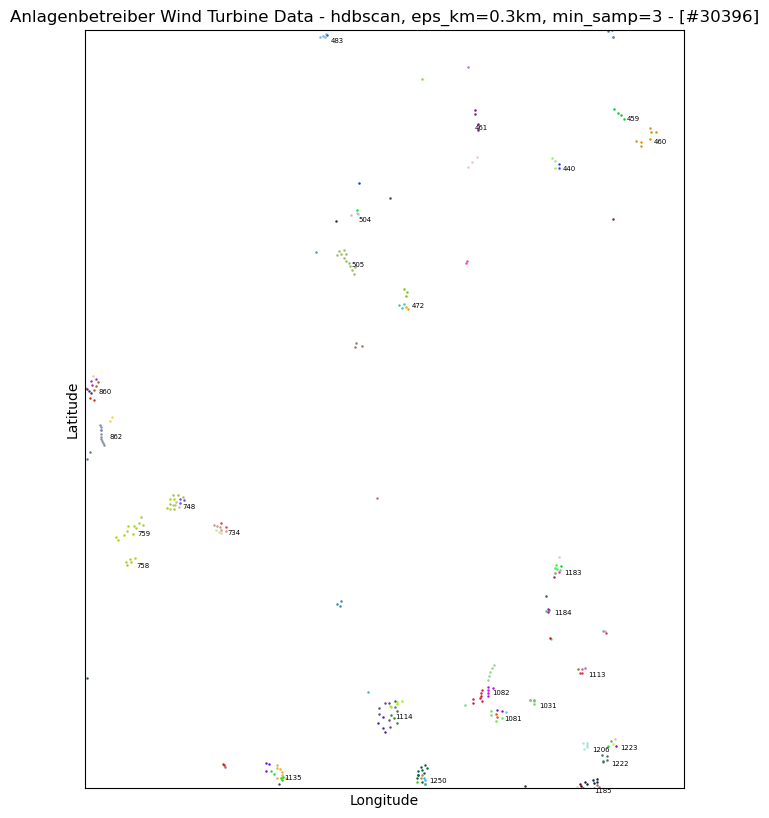

In [212]:
import matplotlib.pyplot as plt
from scipy.spatial import ConvexHull


def plot_anlagenbetreiber(data, cluster_radius, min_samples):
    # Turn the date column into a datetime object
    data['Inbetriebnahmedatum der Einheit'] = pd.to_datetime(data['Inbetriebnahmedatum der Einheit'], format='%d/%m/%Y')

    # TODO: use threshold dates to plot each cluster devided in "Inbetriebnahme Datum"
    threshold_date_str = ["01/01/2013", "01/01/2016", "01/01/2017", "01/01/2020"]
    threshold_dates = [pd.to_datetime(date) for date in threshold_date_str]

    # Convert latitude and longitude to radians and then to a matrix
    coords = data[['latitude', 'longitude']].to_numpy()
    coords_radiant = np.radians(coords)

    eps_km = cluster_radius 

    # Extract the cluster labels
    # labels = db.labels_
    labels = data.cluster.unique()

    # Get unique cluster labels
    unique_labels = np.unique(labels)

    # Create a colormap for the clusters
    colors = plt.cm.Spectral(np.linspace(0, 1, len(unique_labels)))

    # Plot Variables
    image_width_to_height_ratio = (lon_max - lon_min) / (lat_max - lat_min)

    # fig, ax = plt.subplots()
    fig, ax = plt.subplots(figsize=(8, 8 * image_width_to_height_ratio))

    # Create a Basemap instance that aligns with Google Maps projection and bounds
    m = Basemap(projection='merc', llcrnrlat=lat_min, urcrnrlat=lat_max,
                llcrnrlon=lon_min, urcrnrlon=lon_max, lat_ts=20, resolution='i', ax=ax)

    m.drawcoastlines()
    m.drawcountries()


    for cluster in unique_labels:
        if SLICE_DATA:
            # Get mean coordinates for the cluster to place the label
            temp_cluster_df = data[data['cluster'] == cluster]
            mean_x = temp_cluster_df['longitude'].mean()
            mean_y = temp_cluster_df['latitude'].mean()
            x_cluster_label, y_cluster_label = m(mean_x, mean_y)

        
            # Plot the label
            temp_cluster_label = f"{cluster}"
            cluster_label_font_size = 5
            plt.annotate(temp_cluster_label, (x_cluster_label, y_cluster_label), xytext=(5, -5), textcoords='offset points', fontsize=cluster_label_font_size)


    scatter_legends = []
    color_cache = {}

    if SLICE_DATA:
        temp_marker_size = 1
    else:
        temp_marker_size = 0.1

    # Plot labels for each cluster
    # First print out count for each cluster and define colour
    unique_anlagenbetreiber = data['Name des Anlagenbetreibers (nur Org.)'].unique()
    print(f"Algorithm found: {len(unique_anlagenbetreiber)} cluster with {data.shape[0]} data points.")
    for index, temp_anlagenbetreiber in enumerate(unique_anlagenbetreiber):
        if SLICE_DATA:
            marker_size = 3
        else:
            marker_size = 0.1
        
        # Get the number of data points in the cluster
        anlagenbetreiber_count = data[data['Name des Anlagenbetreibers (nur Org.)'] == temp_anlagenbetreiber].shape[0]

        # threshold_date_marker = markers[index]
        # print(f"Cluster: {temp_anlagenbetreiber} [#{anlagenbetreiber_count}]")

        # Generate a random color
        random_color = get_random_color()
        # color_cache[temp_anlagenbetreiber] = random_color

        temp_sliced_df = data[data['Name des Anlagenbetreibers (nur Org.)'] == temp_anlagenbetreiber]
    
        # Convert lat/lon to map projection coordinates
        x, y = m(temp_sliced_df.longitude, temp_sliced_df.latitude)
        temp_label = f"Anlagenbetreiber {temp_anlagenbetreiber}"
        # temp_scatter_legend = m.scatter(x, y, color=color_cache[cluster], marker=threshold_date_marker, s=2, edgecolors='black', linewidth=0.1, label=temp_cluster_label)
        # temp_scatter_legend = m.scatter(x, y, color=color_cache[temp_anlagenbetreiber], s=temp_marker_size, edgecolors='black', linewidth=0.01, label=temp_label)
        temp_scatter = m.scatter(x, y, color=random_color, marker="o", s=marker_size, edgecolors='black', linewidth=0.01)
        scatter_legends.append(temp_scatter)


    # Setting labels and title
    ax.set_xlabel('Longitude')
    ax.set_ylabel('Latitude')
    ax.set_title(f'Anlagenbetreiber Wind Turbine Data - {CLUSTER_ALGO_DECISION}, eps_km={eps_km}km, min_samp={min_samples} - [#{data.shape[0]}]')
    ax.grid(True)
    # ax.legend(handles=scatter_legends, fontsize="xx-small", loc='lower left')

    plt.savefig(PLOT_SAVE_PATH + f"windpark_cluster_plot_anlagenbetreiber_{CLUSTER_ALGO_DECISION}_{eps_km}km_{min_samples}_minSamp.png", dpi=1500, bbox_inches='tight')

    # clear_output(wait=True)

    plt.show()


# len(clustered_wind_df.cluster.unique())
plot_anlagenbetreiber(clustered_wind_df, CLUSTER_RADIUS_KM, MIN_SAMPLES)
# clustered_wind_df.columns

-------------------------------

In [213]:
count = clustered_wind_df[clustered_wind_df['cluster'] != -1]['cluster'].shape[0]
count2 = clustered_wind_df[clustered_wind_df['cluster'] == -1]['cluster'].shape[0]
print(count)
print(count2)


28673
1723


### Single-Marker Plot by vLevel: Function to plot cluster as sigle marker with marker size increasing with cluster size

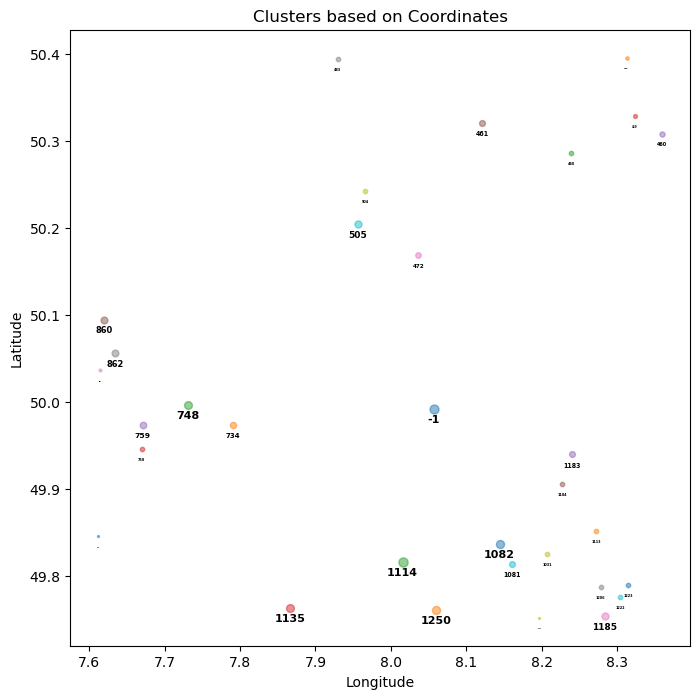

In [214]:
def netzebene_plot_single_clustermarker(df):
    if SLICE_DATA:
        df = df[(df['longitude'] >= lon_min) & (df['longitude'] <= lon_max) & 
                    (df['latitude'] >= lat_min) & (df['latitude'] <= lat_max)]

    # Create a figure with a specific aspect ratio
    fig, ax = plt.subplots(figsize=(8, 8))  # Adjust aspect ratio as needed

    # Set the background color as transparent
    fig.patch.set_alpha(0)
    ax.patch.set_alpha(0)

    # Aggregate data to find centroids and counts per cluster
    cluster_groups = df.groupby('cluster')
    cluster_info = cluster_groups[['latitude', 'longitude']].mean()  # Centroid of each cluster
    cluster_sizes = cluster_groups.size()  # Count of values in each cluster

    # Adjust the scaling factor and add max size
    scale_factor = 2
    max_size = 200

    labeltext_scale_factor = 0.5
    labeltext_max_size = 8

    # Plot one marker per cluster with size based on count
    for cluster_id, centroid in cluster_info.iterrows():
        temp_marker_size = min(cluster_sizes.loc[cluster_id] * scale_factor, max_size)
        temp_fontsize = min(cluster_sizes.loc[cluster_id] * labeltext_scale_factor, labeltext_max_size)
        # temp_marker_size = cluster_sizes.loc[cluster_id] * 2  # Scale size of the marker as needed
        ax.scatter(centroid['longitude'], centroid['latitude'], s=temp_marker_size, alpha=0.5, label=f'Cluster {cluster_id} (n={cluster_sizes.loc[cluster_id]})')
        
        # Adjust the y position of the text label to move it a bit to the bottom
        label_y_position = centroid['latitude'] - 0.012
        # Add cluster_id as label
        ax.text(centroid['longitude'], label_y_position, f'{cluster_id}', ha='center', va='center', fontsize=temp_fontsize, color='black', weight='bold')

    # Setting labels and title
    ax.set_xlabel('Longitude')
    ax.set_ylabel('Latitude')
    ax.set_title('Clusters based on Coordinates')
    # ax.legend(fontsize="x-small", loc='lower left')

    plot_id = str(uuid.uuid4())
    plt.savefig(PLOT_SAVE_PATH + f"windpark_cluster_plot_single_clustermarker_{plot_id}.png", dpi=1500, bbox_inches='tight')

    plt.show()

# Example usage with your DataFrame
netzebene_plot_single_clustermarker(wind_ms_df)



### Single-Marker Plot by Nettonen P

In [242]:
df.iloc[6].Bundesland

'Mecklenburg-Vorpommern'

In [272]:
clustered_wind_df.columns

Index(['Betriebs-Status', 'Energieträger', 'Gemeindeschlüssel',
       'Nettonennleistung der Einheit', 'Bruttoleistung der Einheit',
       'Inbetriebnahmedatum der Einheit', 'Registrierungsdatum der Einheit',
       'Bundesland', 'latitude', 'longitude', 'Name des Windparks',
       'Letzte Aktualisierung', 'Name des Anlagenbetreibers (nur Org.)',
       'Name des Anschluss-Netzbetreibers',
       'MaStR-Nr. des Anschluss-Netzbetreibers', 'Spannungsebene',
       'Inbetriebnahmedatum der EEG-Anlage', 'Spannungsebene_Category',
       'cluster'],
      dtype='object')

In [248]:
test_stuff_df = df.copy()
one_col = test_stuff_df.Bundesland
two_col = test_stuff_df.longitude
type(one_col)


pandas.core.series.Series

Nettonennleistung and Bruttoleisung already in numerical format: Can only use .str accessor with string values!


/var/folders/9r/_jvgz_s166ddc8pfjh0ck_080000gn/T/ipykernel_7358/742309172.py:39: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df["Nettonennleistung der Einheit"] = pd.to_numeric(df["Nettonennleistung der Einheit"], errors='coerce')
/var/folders/9r/_jvgz_s166ddc8pfjh0ck_080000gn/T/ipykernel_7358/742309172.py:40: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df["Bruttoleistung der Einheit"] = pd.to_numeric(df["Bruttoleistung der Einheit"], errors='coerce')


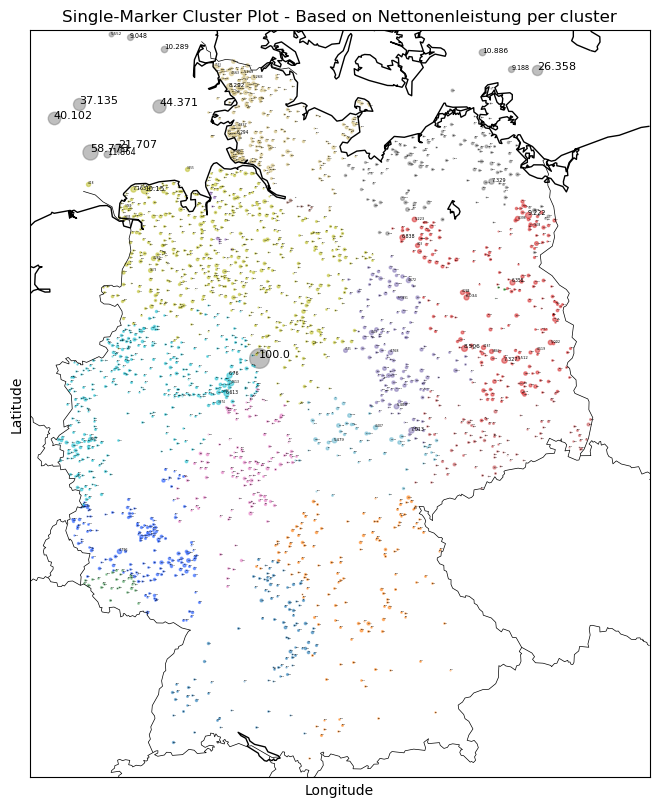

In [279]:
def nettonenP_plot_single_clustermarker(df):
    lon_min, lon_max, lat_min, lat_max = germany_coordinates["lon"][0], germany_coordinates["lon"][1], germany_coordinates["lat"][0], germany_coordinates["lat"][1]
    # if SLICE_DATA:
    df = df[(df['longitude'] >= lon_min) & (df['longitude'] <= lon_max) & 
                (df['latitude'] >= lat_min) & (df['latitude'] <= lat_max)]

    # Plot Variables
    image_width_to_height_ratio = (lon_max - lon_min) / (lat_max - lat_min)

    # fig, ax = plt.subplots()
    fig, ax = plt.subplots(figsize=(8, 8 * image_width_to_height_ratio))

    # Create a Basemap instance that aligns with Google Maps projection and bounds
    m = Basemap(projection='merc', llcrnrlat=lat_min, urcrnrlat=lat_max,
                llcrnrlon=lon_min, urcrnrlon=lon_max, lat_ts=20, resolution='i', ax=ax)

    m.drawcoastlines()
    m.drawcountries()

    # # Set the background color as transparent
    # fig.patch.set_alpha(0)
    # ax.patch.set_alpha(0)

    # Aggregate data to find centroids and counts per cluster
    cluster_groups = df.groupby('cluster')

    # create dictionary of "Bundesland" of each group
    clustergroup_bundesland = {}
    for state_name, cluster_group in cluster_groups:
        clustergroup_bundesland[state_name] = cluster_group.Bundesland.unique()[0]

    # Sum Nettonenleistung per cluster
    # 1. Convert to numerical values
    try:
        df["Nettonennleistung der Einheit"] = df["Nettonennleistung der Einheit"].str.replace(",", ".").astype(float)
        df["Bruttoleistung der Einheit"] = df["Bruttoleistung der Einheit"].str.replace(",", ".").astype(float)
    except AttributeError as err:
        print(f"Nettonennleistung and Bruttoleisung already in numerical format: {err}")
        df["Nettonennleistung der Einheit"] = pd.to_numeric(df["Nettonennleistung der Einheit"], errors='coerce')
        df["Bruttoleistung der Einheit"] = pd.to_numeric(df["Bruttoleistung der Einheit"], errors='coerce')
    # 2. Sum Nettonenleistung per cluster
    nettoP_sums = cluster_groups['Nettonennleistung der Einheit'].sum()
    # 3. Normalize the nettoP_sums to use for marker sizes
    cluster_sizes = (nettoP_sums / nettoP_sums.max()) * 100


    # calculate the mean of each cluster for centered position of the centroid of each cluster
    cluster_info = cluster_groups[['latitude', 'longitude']].mean()  # Centroid of each cluster
    # cluster_sizes = cluster_groups.size()  # Count of values in each cluster

    # Adjust the scaling factor and add max size
    scale_factor = 2
    max_size = 200

    labeltext_scale_factor = 0.5
    labeltext_max_size = 8

    # Define state colors
    # Colors for each state
    # state_colors = [
    #     '#1f77b4', '#ff7f0e', '#2ca02c', '#d62728', '#9467bd', '#8c564b', 
    #     '#e377c2', '#7f7f7f', '#bcbd22', '#17becf', '#1a55FF', '#55a868', 
    #     '#c44e52', '#8172b3', '#ccb974', '#64b5cd'
    # ]
    state_colors = {
        'Baden-Württemberg': '#1f77b4',
        'Bayern': '#ff7f0e',
        'Berlin': '#2ca02c',
        'Brandenburg': '#d62728',
        'Bremen': '#9467bd',
        'Hamburg': '#8c564b',
        'Hessen': '#e377c2',
        'Mecklenburg-Vorpommern': '#7f7f7f',
        'Niedersachsen': '#bcbd22',
        'Nordrhein-Westfalen': '#17becf',
        'Rheinland-Pfalz': '#1a55FF',
        'Saarland': '#55a868',
        'Sachsen': '#c44e52',
        'Sachsen-Anhalt': '#8172b3',
        'Schleswig-Holstein': '#ccb974',
        'Thüringen': '#64b5cd'
    }

    # Plot one marker per cluster with size based on count
    for cluster_id, centroid in cluster_info.iterrows():
        # set marker color based on state
        try:
            if cluster_id == -1:
                temp_marker_color = 'grey'
            else:
                state_name = clustergroup_bundesland[cluster_id]
                temp_marker_color = state_colors[state_name]

        except KeyError as err:
            # print(f"{cluster_id} has no state: {err}")
            temp_marker_color = 'grey'

        # Convert lat/lon to map projection coordinates
        x_pos, y_pos = m(centroid['longitude'], centroid['latitude'])

        temp_marker_size = min(cluster_sizes.loc[cluster_id] * scale_factor, max_size)
        temp_fontsize = min(cluster_sizes.loc[cluster_id] * labeltext_scale_factor, labeltext_max_size)
        # temp_marker_size = cluster_sizes.loc[cluster_id] * 2  # Scale size of the marker as needed
        m.scatter(x_pos, y_pos, s=temp_marker_size, color=temp_marker_color, alpha=0.5, label=f'Cluster {cluster_id} (n={cluster_sizes.loc[cluster_id]})')

        # Plot the label
        temp_cluster_label = f"{round(cluster_sizes.loc[cluster_id], 3)}"
        cluster_label_font_size = temp_fontsize
        # cluster_label_font_size = 5
        label_y_position = y_pos - 0.012
        # plt.annotate(temp_cluster_label, (x_pos, y_pos), xytext=(5, -5), textcoords='offset points', fontsize=cluster_label_font_size)
        plt.annotate(temp_cluster_label, (x_pos, y_pos), fontsize=cluster_label_font_size)


    # Setting labels and title
    ax.set_xlabel('Longitude')
    ax.set_ylabel('Latitude')
    ax.set_title('Single-Marker Cluster Plot - Based on Nettonenleistung per cluster')
    # ax.legend(fontsize="x-small", loc='lower left')

    plot_id = str(uuid.uuid4())
    plt.savefig(PLOT_SAVE_PATH + f"single_clustermarker_plot_by_nettonenleistung_{plot_id}.png", dpi=1500, bbox_inches='tight')

    plt.show()

# Example usage with your DataFrame
nettonenP_plot_single_clustermarker(wind_ms_df)



In [216]:
# # RUN NETZEBENE PLOT FUNCTION
# netzebene_plot_single_clustermarker(wind_ms_df)

In [217]:
data = pd.read_csv(DATA_PATH + "cleaned_data.csv")
data.head()

,MaStR-Nr. der Einheit,Anzeige-Name der Einheit,Betriebs-Status,Energieträger,Bruttoleistung der Einheit,Gemeindeschlüssel,Nettonennleistung der Einheit,Inbetriebnahmedatum der Einheit,Registrierungsdatum der Einheit,latitude,...,\tMaStR-Nr. des Anlagenbetreibers,MaStR-Nr. der Genehmigung,Name des Anschluss-Netzbetreibers,MaStR-Nr. des Anschluss-Netzbetreibers,Netzbetreiberprüfung,Spannungsebene,MaStR-Nr. der Lokation,MaStR-Nr. der EEG-Anlage,Inbetriebnahmedatum der EEG-Anlage,Installierte Leistung der EEG-Anlage
0,SEE907625376308,Eigensonne PV B 3483,In Betrieb,Solare Strahlungsenergie,"7,59",12061572,7,2023-04-04,2023-04-06,NaN,...,ABR991156736885,NaN,E.DIS Netz GmbH (SNB941690671609),SNB941690671609,Geprüft,Niederspannung (= Hausanschluss/Haushaltsstrom),SEL953397567604,EEG935391040611,2023-04-04,"7,59"
1,SEE920990902835,G.P. Batterie,In Betrieb,Speicher,"5,12",12072426,"5,12",2023-03-22,2023-04-06,NaN,...,ABR956544703788,NaN,E.DIS Netz GmbH (SNB941690671609),SNB941690671609,In Prüfung,Niederspannung (= Hausanschluss/Haushaltsstrom),SEL984186068668,EEG978063734890,2023-03-22,NaN
2,SEE911964332840,Eigensonne S B 3483,In Betrieb,Speicher,"3,99",12061572,"3,99",2023-04-04,2023-04-06,NaN,...,ABR991156736885,NaN,E.DIS Netz GmbH (SNB941690671609),SNB941690671609,Geprüft,Niederspannung (= Hausanschluss/Haushaltsstrom),SEL953397567604,EEG914716351748,2023-04-04,NaN
3,SEE951338935130,Balkonsolar,In Betrieb,Solare Strahlungsenergie,"1,48",13072004,"1,48",2023-09-11,2023-09-11,NaN,...,ABR961455993487,NaN,E.DIS Netz GmbH (SNB941690671609),SNB941690671609,In Prüfung,Niederspannung (= Hausanschluss/Haushaltsstrom),SEL928248856879,EEG917438892407,2023-09-11,"1,48"
4,SEE981370660738,Schuppen,In Betrieb,Solare Strahlungsenergie,"0,8",13075036,"0,6",2023-04-01,2023-04-06,NaN,...,ABR904846489503,NaN,E.DIS Netz GmbH (SNB941690671609),SNB941690671609,Geprüft,Niederspannung (= Hausanschluss/Haushaltsstrom),SEL958845505450,EEG939090322313,2023-04-01,"0,8"


In [218]:
# SAVE CLUSTERED DATA
wind_ms_df.to_csv(DATA_PATH + "clustered_wind_df.csv", index=False)


### Plot cluster and noise

Noise: 1723 | Filtered: 28673


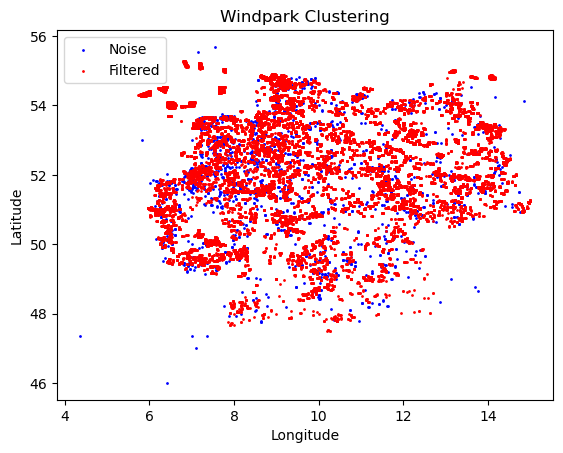

In [219]:
import matplotlib.pyplot as plt

# Filter the dataframe based on the cluster column
noise_df = wind_ms_df[wind_ms_df['cluster'] == -1]
filtered_df = wind_ms_df[wind_ms_df['cluster'] != -1]

# Create a scatter plot with different colors for each dataframe
plt.scatter(noise_df['longitude'], noise_df['latitude'], color='blue', label='Noise', s=1)
plt.scatter(filtered_df['longitude'], filtered_df['latitude'], color='red', label='Filtered', s=1)

print(f"Noise: {noise_df.shape[0]} | Filtered: {filtered_df.shape[0]}")

# Set the x and y axis labels
plt.xlabel('Longitude')
plt.ylabel('Latitude')

# Set the title of the plot
plt.title('Windpark Clustering')

# Add a legend
plt.legend()

# Show the plot
plt.show()


# Clusterd Data Insights

In [220]:
clustered_wind_df.columns

Index(['Betriebs-Status', 'Energieträger', 'Gemeindeschlüssel',
       'Nettonennleistung der Einheit', 'Bruttoleistung der Einheit',
       'Inbetriebnahmedatum der Einheit', 'Registrierungsdatum der Einheit',
       'Bundesland', 'latitude', 'longitude', 'Name des Windparks',
       'Letzte Aktualisierung', 'Name des Anlagenbetreibers (nur Org.)',
       'Name des Anschluss-Netzbetreibers',
       'MaStR-Nr. des Anschluss-Netzbetreibers', 'Spannungsebene',
       'Inbetriebnahmedatum der EEG-Anlage', 'Spannungsebene_Category',
       'cluster'],
      dtype='object')

In [221]:
grouped_df = clustered_wind_df.groupby('cluster')
cluster_vLevel_count = grouped_df['Spannungsebene_Category'].value_counts()
# cluster_vLevel_count.to_csv(DATA_PATH + 'cluster_vLevel_count.txt', sep='\t')


average "Spannungsebenen" per cluster

In [222]:
mean_spannungsebene_per_cluster = grouped_df['Spannungsebene_Category'].nunique().mean()
print(mean_spannungsebene_per_cluster)

1.5254237288135593


In [223]:
# german_states_coordinates = {
#     "Baden-Württemberg": {"Latitude": (47.5, 49.8), "Longitude": (7.5, 10.5)},
#     "Bavaria (Bayern)": {"Latitude": (47.3, 50.6), "Longitude": (8.9, 13.8)},
#     "Berlin": {"Latitude": (52.3, 52.7), "Longitude": (13.1, 13.8)},
#     "Brandenburg": {"Latitude": (51.4, 53.6), "Longitude": (11.3, 14.8)},
#     "Bremen": {"Latitude": (53.0, 53.6), "Longitude": (8.5, 8.9)},
#     "Hamburg": {"Latitude": (53.4, 53.7), "Longitude": (9.7, 10.3)},
#     "Hesse (Hessen)": {"Latitude": (49.4, 51.7), "Longitude": (7.7, 10.2)},
#     "Lower Saxony (Niedersachsen)": {"Latitude": (51.3, 54.0), "Longitude": (6.5, 11.5)},
#     "Mecklenburg-Western Pomerania (Mecklenburg-Vorpommern)": {"Latitude": (53.1, 54.5), "Longitude": (10.6, 14.4)},
#     "North Rhine-Westphalia (Nordrhein-Westfalen)": {"Latitude": (50.3, 52.6), "Longitude": (5.8, 9.5)},
#     "Rhineland-Palatinate (Rheinland-Pfalz)": {"Latitude": (48.9, 51.7), "Longitude": (6.0, 8.4)},
#     "Saarland": {"Latitude": (49.1, 49.7), "Longitude": (6.3, 7.4)},
#     "Saxony (Sachsen)": {"Latitude": (50.2, 51.7), "Longitude": (11.9, 15.0)},
#     "Saxony-Anhalt (Sachsen-Anhalt)": {"Latitude": (51.0, 53.0), "Longitude": (10.6, 13.2)},
#     "Schleswig-Holstein": {"Latitude": (53.3, 55.1), "Longitude": (7.5, 11.4)},
#     "Thuringia (Thüringen)": {"Latitude": (50.2, 51.6), "Longitude": (9.8, 12.7)},
#     "Germany (Deutschland)": {"Latitude": (47.3, 55.2), "Longitude": (5.5, 16.0)}
# }

# german_states_area_size = {
#     "Baden-Württemberg": 35748,
#     "Bavaria (Bayern)": 70542,
#     "Berlin": 891.8,
#     "Brandenburg": 29654,
#     "Bremen": 404.2,
#     "Hamburg": 755.3,
#     "Hesse (Hessen)": 21115,
#     "Lower Saxony (Niedersachsen)": 47709,
#     "Mecklenburg-Western Pomerania (Mecklenburg-Vorpommern)": 23214,
#     "North Rhine-Westphalia (Nordrhein-Westfalen)": 34085,
#     "Rhineland-Palatinate (Rheinland-Pfalz)": 19853,
#     "Saarland": 2569,
#     "Saxony (Sachsen)": 18416,
#     "Saxony-Anhalt (Sachsen-Anhalt)": 20452,
#     "Schleswig-Holstein": 15799,
#     "Thuringia (Thüringen)": 16172,
#     "Germany (Deutschland)": 357022
# }

german_states_coordinates = {
    "Baden-Württemberg": {"Latitude": (47.5, 49.8), "Longitude": (7.5, 10.5)},
    "Bavaria (Bayern)": {"Latitude": (47.3, 50.6), "Longitude": (8.9, 13.8)},
    "Berlin": {"Latitude": (52.3, 52.7), "Longitude": (13.1, 13.8)},
    "Brandenburg": {"Latitude": (51.4, 53.6), "Longitude": (11.3, 14.8)},
    "Bremen": {"Latitude": (53.0, 53.6), "Longitude": (8.5, 8.9)},
    "Hamburg": {"Latitude": (53.4, 53.7), "Longitude": (9.7, 10.3)},
    "Hesse (Hessen)": {"Latitude": (49.4, 51.7), "Longitude": (7.7, 10.2)},
    "Lower Saxony (Niedersachsen)": {"Latitude": (51.3, 54.0), "Longitude": (6.5, 11.5)},
    "Mecklenburg-Western Pomerania (Mecklenburg-Vorpommern)": {"Latitude": (53.1, 54.5), "Longitude": (10.6, 14.4)},
    "North Rhine-Westphalia (Nordrhein-Westfalen)": {"Latitude": (50.3, 52.6), "Longitude": (5.8, 9.5)},
    "Rhineland-Palatinate (Rheinland-Pfalz)": {"Latitude": (48.9, 51.7), "Longitude": (6.0, 8.4)},
    "Saarland": {"Latitude": (49.1, 49.7), "Longitude": (6.3, 7.4)},
    "Saxony (Sachsen)": {"Latitude": (50.2, 51.7), "Longitude": (11.9, 15.0)},
    "Saxony-Anhalt (Sachsen-Anhalt)": {"Latitude": (51.0, 53.0), "Longitude": (10.6, 13.2)},
    "Schleswig-Holstein": {"Latitude": (53.3, 55.1), "Longitude": (7.5, 11.4)},
    "Thuringia (Thüringen)": {"Latitude": (50.2, 51.6), "Longitude": (9.8, 12.7)}
}

german_states_area_size = {
    "Baden-Württemberg": 35748,
    "Bavaria (Bayern)": 70542,
    "Berlin": 891.8,
    "Brandenburg": 29654,
    "Bremen": 404.2,
    "Hamburg": 755.3,
    "Hesse (Hessen)": 21115,
    "Lower Saxony (Niedersachsen)": 47709,
    "Mecklenburg-Western Pomerania (Mecklenburg-Vorpommern)": 23214,
    "North Rhine-Westphalia (Nordrhein-Westfalen)": 34085,
    "Rhineland-Palatinate (Rheinland-Pfalz)": 19853,
    "Saarland": 2569,
    "Saxony (Sachsen)": 18416,
    "Saxony-Anhalt (Sachsen-Anhalt)": 20452,
    "Schleswig-Holstein": 15799,
    "Thuringia (Thüringen)": 16172
}

In [224]:
# Function to split germany in grid of 50x50 squares
def split_into_grid(min_lon, max_lon, min_lat, max_lat, grid_size=50):
    # Calculate step sizes
    lon_step = (lon_max - lon_min) / grid_size
    lat_step = (lat_max - lat_min) / grid_size
    
    grid_coordinates = []

    # Generate the grid
    for i in range(grid_size):
        for j in range(grid_size):
            # Calculate min and max coordinates for each square
            square_min_lon = lon_min + lon_step * j
            square_max_lon = square_min_lon + lon_step
            square_min_lat = lat_min + lat_step * i
            square_max_lat = square_min_lat + lat_step
            
            # Append the coordinates to the list
            grid_coordinates.append({
                'lon_min': square_min_lon,
                'lon_max': square_max_lon,
                'lat_min': square_min_lat,
                'lat_max': square_max_lat
            })

    return grid_coordinates

# Get the grid coordinates
grid_coordinates = split_into_grid(lon_min, lon_max, lat_min, lat_max)


### Function to get data insights of clustered data

In [225]:
temp_cp = clustered_wind_df.copy()
try:
    temp_cp["Nettonennleistung der Einheit"] = clustered_wind_df["Nettonennleistung der Einheit"].str.replace(",", ".")
except AttributeError as err:
    print(f"'Nettonenleistung' already cleand: {err}")
    
pd.to_numeric(temp_cp["Nettonennleistung der Einheit"])

0         600.0
1         600.0
2         600.0
3         600.0
4         600.0
          ...  
30391     250.0
30392     250.0
30393    2300.0
30394     660.0
30395     600.0
Name: Nettonennleistung der Einheit, Length: 30396, dtype: float64

In [226]:

def get_data_insights(df, german_states_coordinates):
    states_data = []

    for state, coordinates in german_states_coordinates.items():
        temp_df_slice = clustered_wind_df[(df['longitude'] >= coordinates['Longitude'][0]) & 
                                            (df['longitude'] <= coordinates['Longitude'][1]) & 
                                            (df['latitude'] >= coordinates['Latitude'][0]) & 
                                            (df['latitude'] <= coordinates['Latitude'][1])]

        # Average number of different voltage levels per cluster
        grouped_df = temp_df_slice.groupby('cluster')
        mean_spannungsebene_per_cluster = round(grouped_df['Spannungsebene_Category'].nunique().mean(), 3)

        # Average Inbetriebnahmedatum
        df['Inbetriebnahmedatum der Einheit'] = pd.to_numeric(df['Inbetriebnahmedatum der Einheit'], errors='coerce')
        # Calculate the average value for each cluster
        cluster_avg = temp_df_slice.groupby('cluster')['Inbetriebnahmedatum der Einheit'].mean()
        # Calculate the average value for all clusters
        overall_avg = temp_df_slice['Inbetriebnahmedatum der Einheit'].mean()
        # Convert the average timestamp values back to datetime format
        cluster_avg_datetime = pd.to_datetime(cluster_avg, unit='ns')
        overall_avg_datetime = pd.to_datetime(overall_avg, unit='ns')
        overall_avg_date = overall_avg_datetime.date()

        # Convert to numerical values
        try:
            df["Nettonennleistung der Einheit"] = df["Nettonennleistung der Einheit"].str.replace(",", ".").astype(float)
            df["Bruttoleistung der Einheit"] = df["Bruttoleistung der Einheit"].str.replace(",", ".").astype(float)
        except AttributeError as err:
            print(f"Nettonennleistung and Bruttoleisung already in numerical format: {err}")
            df["Nettonennleistung der Einheit"] = pd.to_numeric(df["Nettonennleistung der Einheit"], errors='coerce')
            df["Bruttoleistung der Einheit"] = pd.to_numeric(df["Bruttoleistung der Einheit"], errors='coerce')

        # Average Leistung
        # FIXME: The Netto and Brutto Leisung are the same in the dataste
        mean_nettoP_per_cluster = round(temp_df_slice.groupby('cluster')['Nettonennleistung der Einheit'].mean().mean(), 3)
        mean_bruttoP_per_cluster = round(temp_df_slice.groupby('cluster')['Bruttoleistung der Einheit'].mean().mean(), 3)
        # mean_bruttoP_per_cluster = round(temp_df_slice['Bruttoleistung der Einheit'].mean(), 3)

        # Average most common V-Level per cluster
        # Determine the most common "Spannungsebene_Category" for each cluster
        most_common_per_cluster = clustered_wind_df.groupby('cluster')['Spannungsebene_Category'].agg(lambda x: x.mode()[0]).reset_index(name='MostCommonCategory')
        # Find the most frequently occurring "Spannungsebene_Category" across all clusters
        most_common_vLevel = most_common_per_cluster['MostCommonCategory'].mode()[0]

        # Avg wind turbines per cluster
        cluster_counts = temp_df_slice.groupby('cluster').size()
        average_count_per_cluster = cluster_counts.mean()


        # print(f"State: {state} | Data points: {temp_df_slice.shape[0]} | Cluster: {temp_df_slice['cluster'].nunique(), "Avg vLevel per cluster": mean_spannungsebene_per_cluster}")
        states_data.append({'State': state, 
                            'Wind Turbines Count': temp_df_slice.shape[0], 
                            'Cluster': temp_df_slice['cluster'].nunique(), 
                            'Avg vLevels count per cluster': mean_spannungsebene_per_cluster,
                            'Avg Inbetriebnahmedatum': overall_avg_date,
                            'Avg Nettonen P': mean_nettoP_per_cluster,
                            'Avg Brutto P': mean_bruttoP_per_cluster,
                            'Avg V-Level': most_common_vLevel,
                            'Avg cluster size': average_count_per_cluster,
                            'State lon': (coordinates['Longitude'][0], coordinates['Longitude'][1]),
                            'State lat': (coordinates['Latitude'][0], coordinates['Latitude'][1])
                            })
        

    insights_df = pd.DataFrame(states_data)
    insights_df.to_csv(DATA_PATH + 'insights_data_w_umspannebene.csv', index=False)

    return insights_df

insights_df = get_data_insights(clustered_wind_df, german_states_coordinates)
insights_df

Nettonennleistung and Bruttoleisung already in numerical format: Can only use .str accessor with string values!
Nettonennleistung and Bruttoleisung already in numerical format: Can only use .str accessor with string values!
Nettonennleistung and Bruttoleisung already in numerical format: Can only use .str accessor with string values!
Nettonennleistung and Bruttoleisung already in numerical format: Can only use .str accessor with string values!
Nettonennleistung and Bruttoleisung already in numerical format: Can only use .str accessor with string values!
Nettonennleistung and Bruttoleisung already in numerical format: Can only use .str accessor with string values!
Nettonennleistung and Bruttoleisung already in numerical format: Can only use .str accessor with string values!
Nettonennleistung and Bruttoleisung already in numerical format: Can only use .str accessor with string values!
Nettonennleistung and Bruttoleisung already in numerical format: Can only use .str accessor with string 

Nettonennleistung and Bruttoleisung already in numerical format: Can only use .str accessor with string values!
Nettonennleistung and Bruttoleisung already in numerical format: Can only use .str accessor with string values!
Nettonennleistung and Bruttoleisung already in numerical format: Can only use .str accessor with string values!
Nettonennleistung and Bruttoleisung already in numerical format: Can only use .str accessor with string values!
Nettonennleistung and Bruttoleisung already in numerical format: Can only use .str accessor with string values!


,State,Wind Turbines Count,Cluster,Avg vLevels count per cluster,Avg Inbetriebnahmedatum,Avg Nettonen P,Avg Brutto P,Avg V-Level,Avg cluster size,State lon,State lat
0,Baden-Württemberg,1501,172,1.360,2011-06-06,inf,inf,Mittelspannung,8.726744,"(7.5, 10.5)","(47.5, 49.8)"
1,Bavaria (Bayern),2053,248,1.310,2011-07-30,2256.295,2256.295,Mittelspannung,8.278226,"(8.9, 13.8)","(47.3, 50.6)"
2,Berlin,165,14,1.929,2013-05-02,2465.024,2465.024,Mittelspannung,11.785714,"(13.1, 13.8)","(52.3, 52.7)"
3,Brandenburg,6698,357,1.770,2008-11-03,1992.657,1992.657,Mittelspannung,18.761905,"(11.3, 14.8)","(51.4, 53.6)"
4,Bremen,258,28,1.429,2008-01-25,1927.440,1927.440,Mittelspannung,9.214286,"(8.5, 8.9)","(53.0, 53.6)"
5,Hamburg,80,10,1.600,2009-07-29,1659.734,1659.734,Mittelspannung,8.000000,"(9.7, 10.3)","(53.4, 53.7)"
6,Hesse (Hessen),3295,324,1.333,2009-12-13,2064.015,2064.015,Mittelspannung,10.169753,"(7.7, 10.2)","(49.4, 51.7)"
7,Lower Saxony (Niedersachsen),11247,966,1.507,2008-06-20,2027.652,2027.652,Mittelspannung,11.642857,"(6.5, 11.5)","(51.3, 54.0)"
8,Mecklenburg-Western Pomerania (Mecklenburg-Vor...,3313,213,1.836,2008-07-22,2066.689,2066.689,Mittelspannung,15.553991,"(10.6, 14.4)","(53.1, 54.5)"
9,North Rhine-Westphalia (Nordrhein-Westfalen),5420,530,1.385,2009-01-14,1965.559,1965.559,Mittelspannung,10.226415,"(5.8, 9.5)","(50.3, 52.6)"


In [227]:
clustered_wind_df.Spannungsebene_Category.value_counts()

Mittelspannung                                14381
Hochspannung                                   8993
Umspannebene Hochspannung/Mittelspannung       4171
Höchstspannung                                 2331
Niederspannung                                  280
Umspannebene Mittelspannung/Niederspannung      172
Umspannebene Höchstspannung/Hochspannung         68
Name: Spannungsebene_Category, dtype: int64

In [228]:
# Step 1: Group by cluster and Spannungsebene_Category and count occurrences
cluster_category_counts = clustered_wind_df.groupby(['cluster', 'Spannungsebene_Category']).size().reset_index(name='count')

# Step 2: Find the most common category in each cluster
most_common_per_cluster = cluster_category_counts.loc[cluster_category_counts.groupby(['cluster'])['count'].idxmax()]

# Calculate the average count (frequency) of the most common category in each cluster
average_freq_per_cluster = most_common_per_cluster['count'].mean()

print("Average frequency of the most common 'Spannungsebene_Category' per cluster:", average_freq_per_cluster)

Average frequency of the most common 'Spannungsebene_Category' per cluster: 10.648305084745763


In [229]:

# Step 1: Determine the most common "Spannungsebene_Category" for each cluster
most_common_per_cluster = clustered_wind_df.groupby('cluster')['Spannungsebene_Category'].agg(lambda x: x.mode()[0]).reset_index(name='MostCommonCategory')

# Step 2: Find the most frequently occurring "Spannungsebene_Category" across all clusters
most_common_overall = most_common_per_cluster['MostCommonCategory'].mode()[0]

print(f"The most frequently occurring 'Spannungsebene_Category' across all clusters is: {most_common_overall}")


The most frequently occurring 'Spannungsebene_Category' across all clusters is: Mittelspannung


## Plot cluster insight dataframe

In [230]:
INSIGHTS_PLOT_DPI = 1000

In [231]:
clustered_wind_df.columns

Index(['Betriebs-Status', 'Energieträger', 'Gemeindeschlüssel',
       'Nettonennleistung der Einheit', 'Bruttoleistung der Einheit',
       'Inbetriebnahmedatum der Einheit', 'Registrierungsdatum der Einheit',
       'Bundesland', 'latitude', 'longitude', 'Name des Windparks',
       'Letzte Aktualisierung', 'Name des Anlagenbetreibers (nur Org.)',
       'Name des Anschluss-Netzbetreibers',
       'MaStR-Nr. des Anschluss-Netzbetreibers', 'Spannungsebene',
       'Inbetriebnahmedatum der EEG-Anlage', 'Spannungsebene_Category',
       'cluster'],
      dtype='object')

In [232]:
insights_df.head()

,State,Wind Turbines Count,Cluster,Avg vLevels count per cluster,Avg Inbetriebnahmedatum,Avg Nettonen P,Avg Brutto P,Avg V-Level,Avg cluster size,State lon,State lat
0,Baden-Württemberg,1501,172,1.360,2011-06-06,inf,inf,Mittelspannung,8.726744,"(7.5, 10.5)","(47.5, 49.8)"
1,Bavaria (Bayern),2053,248,1.310,2011-07-30,2256.295,2256.295,Mittelspannung,8.278226,"(8.9, 13.8)","(47.3, 50.6)"
2,Berlin,165,14,1.929,2013-05-02,2465.024,2465.024,Mittelspannung,11.785714,"(13.1, 13.8)","(52.3, 52.7)"
3,Brandenburg,6698,357,1.770,2008-11-03,1992.657,1992.657,Mittelspannung,18.761905,"(11.3, 14.8)","(51.4, 53.6)"
4,Bremen,258,28,1.429,2008-01-25,1927.440,1927.440,Mittelspannung,9.214286,"(8.5, 8.9)","(53.0, 53.6)"


Helper function to only get german names of states

In [233]:
def get_german_state_names(df) -> [str]:
    state_name_list = df["State"].tolist()
    return [state_name.split("(")[-1].replace(")", "") for state_name in state_name_list]

### 0. Germany map plot distinguished by state

In [234]:
def data_plot_ULevel(df, german_state_data):

    # # Define color mapping
    # color_map = {
    #     'Niederspannung': 'green',
    #     'Mittelspannung': 'blue',
    #     'Hochspannung': 'orange',
    #     'Höchstspannung': 'red',
    #     'Umspannebene Umspannebene Mittelspannung/Niederspannung': 'purple',
    #     'Umspannebene Hochspannung/Mittelspannung': 'cyan',
    #     'Umspannebene Höchstspannung/Hochspannung': 'magenta',
    #     'Other': 'gray'  # For any category that doesn't match the specified ones
    # }
    
    # Example value of german_states_coordinates dict: "Baden-Württemberg": {"Latitude": (47.5, 49.8), "Longitude": (7.5, 10.5)},

    de_state_name_list = german_states_coordinates.keys()
    
    for index, state in enumerate(german_states_coordinates):
        min
    

    # Calculate aspect ratio
    image_width_to_height_ratio = (lon_max - lon_min) / (lat_max - lat_min)

    # Create a figure with the same aspect ratio
    fig, ax = plt.subplots(figsize=(8, 8 * image_width_to_height_ratio))

    # Set the background color as transparent
    # fig.patch.set_alpha(0)
    # ax.patch.set_alpha(0)

    # Create a Basemap instance that aligns with Google Maps projection and bounds
    m = Basemap(projection='merc', llcrnrlat=lat_min, urcrnrlat=lat_max,
                llcrnrlon=lon_min, urcrnrlon=lon_max, lat_ts=20, resolution='i', ax=ax)

    m.drawcoastlines()
    m.drawcountries()

    # Convert lat/long to map projection coordinates
    x, y = m(df.longitude, df.latitude)

    if df.shape[0] < 50:
        maker_size = 10
    else:
        maker_size = 3

    scatter_legends = []
    for category, color in color_map.items():
        subset = df[df['Spannungsebene_Category'] == category]
        temp_label = f"[#{subset.shape[0]}] - {category}" if subset.shape[0] != 0 else f"{category}"
        x_temp, y_temp = m(subset.longitude, subset.latitude)
        # define marker based on if Umspannebene or normal Spannungsebene
        if "Umspannebene" in category:
            temp_marker = "s"
        else:
            temp_marker = "o"
        scatter = m.scatter(x_temp, y_temp, alpha=0.9, marker=temp_marker, s=maker_size, color=color, label=temp_label, edgecolors='black', linewidth=0.2)
        scatter_legends.append(scatter)
    
    text_box_string = f"Slice Coordinates:\nLat: {round(lat_min, 2)} - {round(lat_max, 2)}\nLon: {round(lon_min, 2)} - {round(lon_max, 2)}"

    # Add a text box
    plt.text(0.805, 0.015, text_box_string, bbox=dict(facecolor='grey', alpha=0.3, pad=5), 
            horizontalalignment='left', verticalalignment='bottom', 
            transform=plt.gca().transAxes, fontsize=8)

    # Setting labels and title
    ax.set_xlabel('Longitude')
    ax.set_ylabel('Latitude')
    ax.set_title(f'Wind Farm Data Slice - differentiated in voltage level [#{df.shape[0]}]')
    ax.grid(True)
    ax.legend(handles=scatter_legends, fontsize="x-small", loc='lower left')

    plot_id = str(uuid.uuid4())
    # plt.savefig(plot_save_path + "wind_ms_all_data_plot.png", dpi=plot_save_resolution, bbox_inches='tight', transparent=True)
    plt.savefig(PLOT_SAVE_PATH + f"wind_ULevel_data_plot_{plot_id}.png", dpi=PLOT_SAVE_RESOLUTION, bbox_inches='tight')
    
    plt.show()


# # RUN PLOT FUNCTION
# data_plot_ULevel(wind_ms_df, lat_min, lat_max, lon_min, lon_max)

### 1. Number of Wind Turbines by State

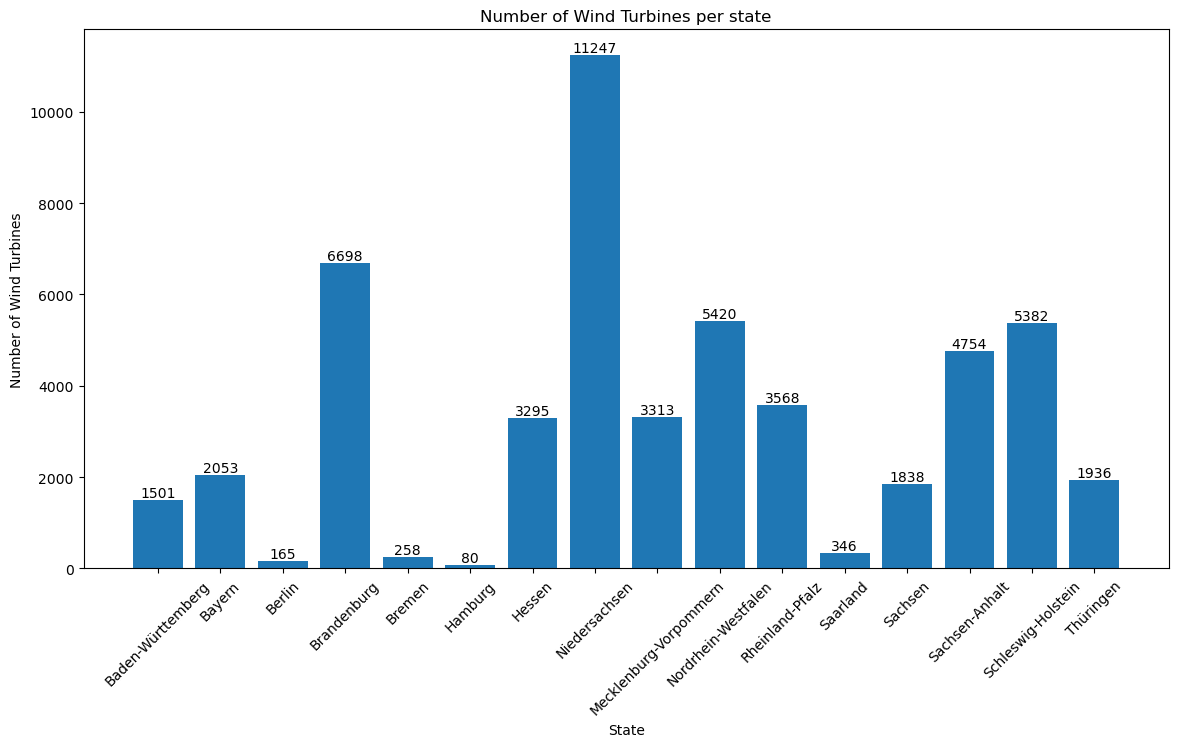

In [235]:
def plot_WT_count(df):
    de_state_name_list = get_german_state_names(df)

    plt.figure(figsize=(14, 7))
    bars = plt.bar(de_state_name_list, df["Wind Turbines Count"])
    plt.title('Number of Wind Turbines per state')
    plt.ylabel("Number of Wind Turbines")
    plt.xlabel("State")
    plt.xticks(rotation=45)

    for bar in bars:
        yval = bar.get_height()
        plt.text(bar.get_x() + bar.get_width()/2, yval, round(yval, 2), ha='center', va='bottom')

    # Save the plot
    plot_id = str(uuid.uuid4())
    plt.savefig(PLOT_SAVE_PATH + f"wp_cluster_insights_plot_wt_count_{plot_id}.png", dpi=INSIGHTS_PLOT_DPI, bbox_inches='tight')    

    plt.show()

plot_WT_count(insights_df)

### 2. Occupied Wind Turbine Area and Area/StateSize Ratio

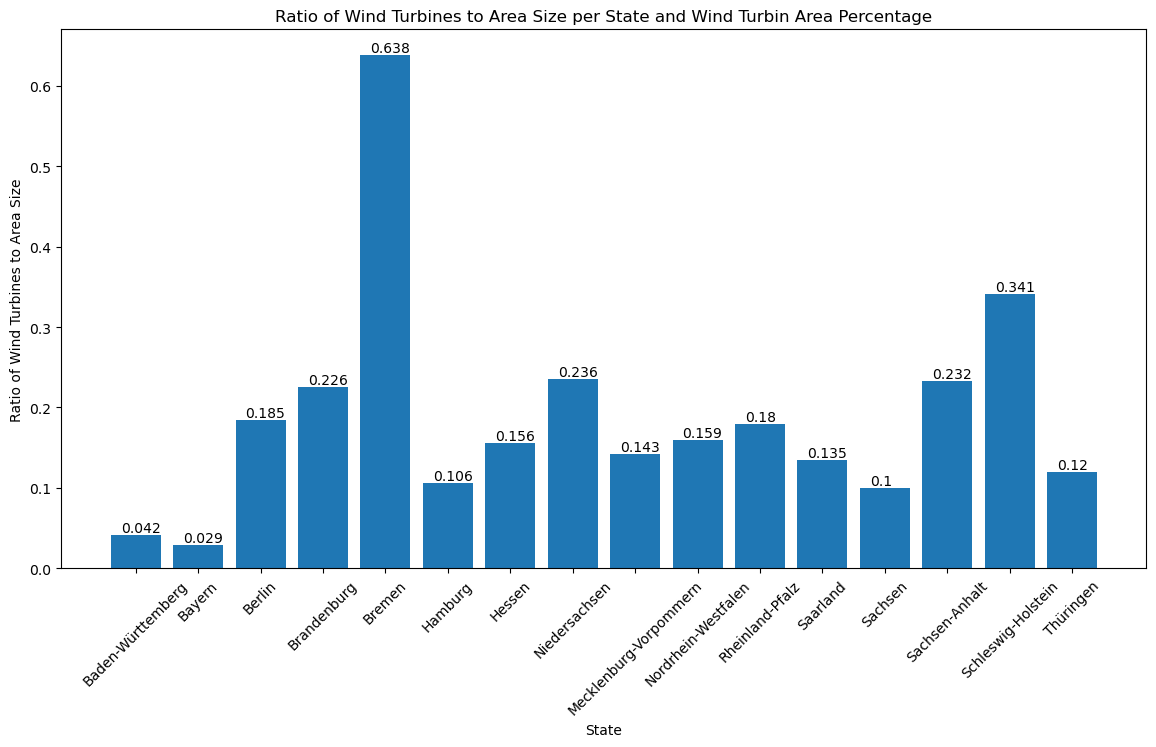

In [236]:
def plot_wt_occupied_area(df):
    de_state_name_list = get_german_state_names(df)

    # Calculate the ratio and store it in a new column
    insights_df['Turbines/Area'] = df.apply(lambda row: row['Wind Turbines Count'] / german_states_area_size[row['State']], axis=1)

    # Create figure with two subplots
    plt.figure(figsize=(14, 7))

    # 1. Plot the ratio
    bars1 = plt.bar(de_state_name_list, df['Turbines/Area'], label="Turbines/Area Ratio")
    plt.title('Ratio of Wind Turbines to Area Size per State and Wind Turbin Area Percentage')
    plt.ylabel("Ratio of Wind Turbines to Area Size")
    plt.xlabel("State")
    plt.xticks(rotation=45)

    # Add y-axis values to bars
    # wt_occupied_area_pec = df['Turbines Occupied Area (%)'].to_list()
    for index, bar in enumerate(bars1):
        yval = bar.get_height()
        plt.text(bar.get_x() + bar.get_width()/5, yval, f"{round(yval, 3)}", va='bottom', rotation=0)  # va: vertical alignment
        # f"{round(wt_occupied_area_pec[index]

    # Save the plot
    plot_id = str(uuid.uuid4())
    plt.savefig(PLOT_SAVE_PATH + f"wp_cluster_insights_plot_wt_occupied_area_ratio_{plot_id}.png", dpi=INSIGHTS_PLOT_DPI, bbox_inches='tight')    

    plt.show()

plot_wt_occupied_area(insights_df)

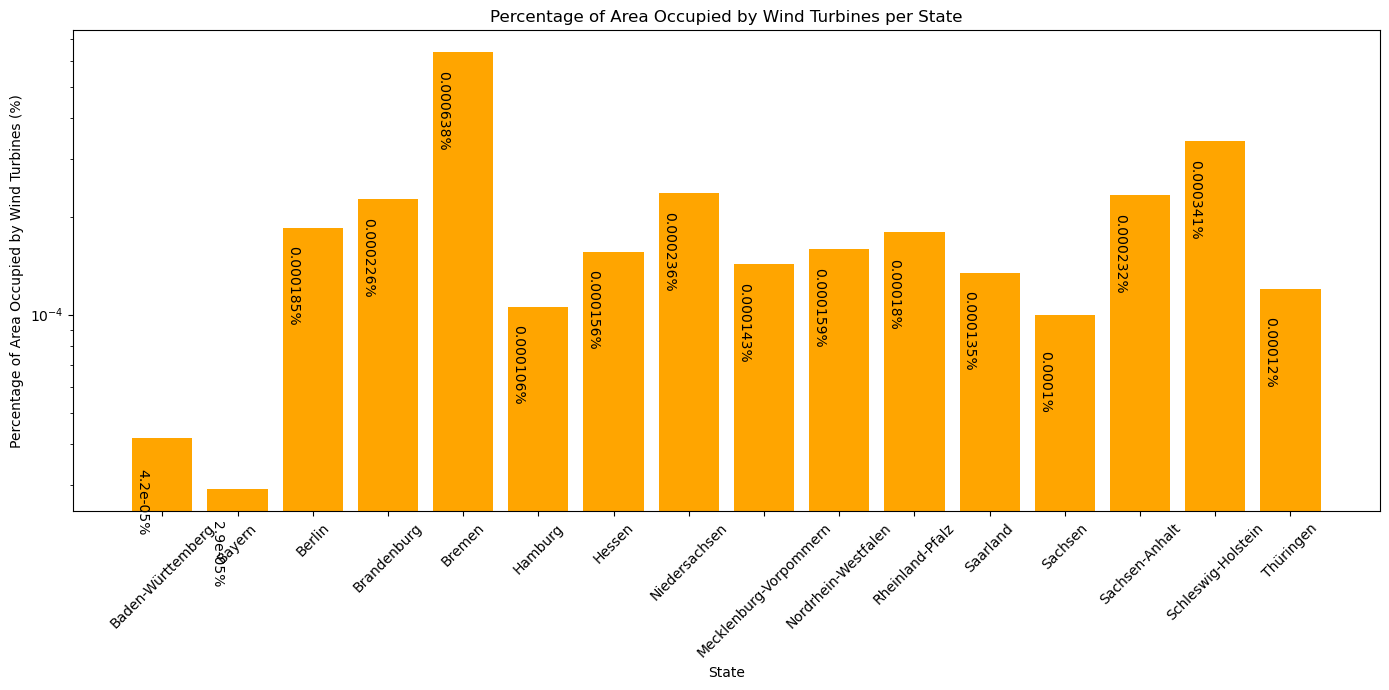

In [237]:
def plot_WT_occupied_prc(df):
    de_state_name_list = get_german_state_names(df)

    # Create figure with two subplots
    plt.figure(figsize=(14, 7))

    # 1km^2 = 1.000.000 m^2
    km2_to_m2 = 1_000_000
    insights_df['Turbines Occupied Area (%)'] = df.apply(lambda row: (row['Wind Turbines Count'] * 10 / (german_states_area_size[row['State']] * km2_to_m2)) * 100, axis=1)

    # 2. Plot the percentage
    bars2 = plt.bar(de_state_name_list, df['Turbines Occupied Area (%)'], color="orange", label='Turbines Occupied Area (%)')
    plt.title('Percentage of Area Occupied by Wind Turbines per State')
    plt.ylabel("Percentage of Area Occupied by Wind Turbines (%)")
    plt.xlabel("State")
    plt.xticks(rotation=45)

    for index, bar in enumerate(bars2):
        yval = bar.get_height()
        plt.text(bar.get_x() + bar.get_width()/20, yval/2, f"{round(yval, 6)}%", va='bottom', rotation=-90)  # va: vertical alignment
    
    # Use a logarithmic scale for the y-axis
    plt.semilogy()

    plt.tight_layout()

    # Save the plot
    plot_id = str(uuid.uuid4())
    plt.savefig(PLOT_SAVE_PATH + f"wp_cluster_insights_plot_wt_occupied_area_percentage_{plot_id}.png", dpi=INSIGHTS_PLOT_DPI, bbox_inches='tight')    

    plt.show()

plot_WT_occupied_prc(insights_df)

In [238]:
insights_df.head()

,State,Wind Turbines Count,Cluster,Avg vLevels count per cluster,Avg Inbetriebnahmedatum,Avg Nettonen P,Avg Brutto P,Avg V-Level,Avg cluster size,State lon,State lat,Turbines/Area,Turbines Occupied Area (%)
0,Baden-Württemberg,1501,172,1.360,2011-06-06,inf,inf,Mittelspannung,8.726744,"(7.5, 10.5)","(47.5, 49.8)",0.041988,0.000042
1,Bavaria (Bayern),2053,248,1.310,2011-07-30,2256.295,2256.295,Mittelspannung,8.278226,"(8.9, 13.8)","(47.3, 50.6)",0.029103,0.000029
2,Berlin,165,14,1.929,2013-05-02,2465.024,2465.024,Mittelspannung,11.785714,"(13.1, 13.8)","(52.3, 52.7)",0.185019,0.000185
3,Brandenburg,6698,357,1.770,2008-11-03,1992.657,1992.657,Mittelspannung,18.761905,"(11.3, 14.8)","(51.4, 53.6)",0.225872,0.000226
4,Bremen,258,28,1.429,2008-01-25,1927.440,1927.440,Mittelspannung,9.214286,"(8.5, 8.9)","(53.0, 53.6)",0.638298,0.000638


posx and posy should be finite values
posx and posy should be finite values
posx and posy should be finite values


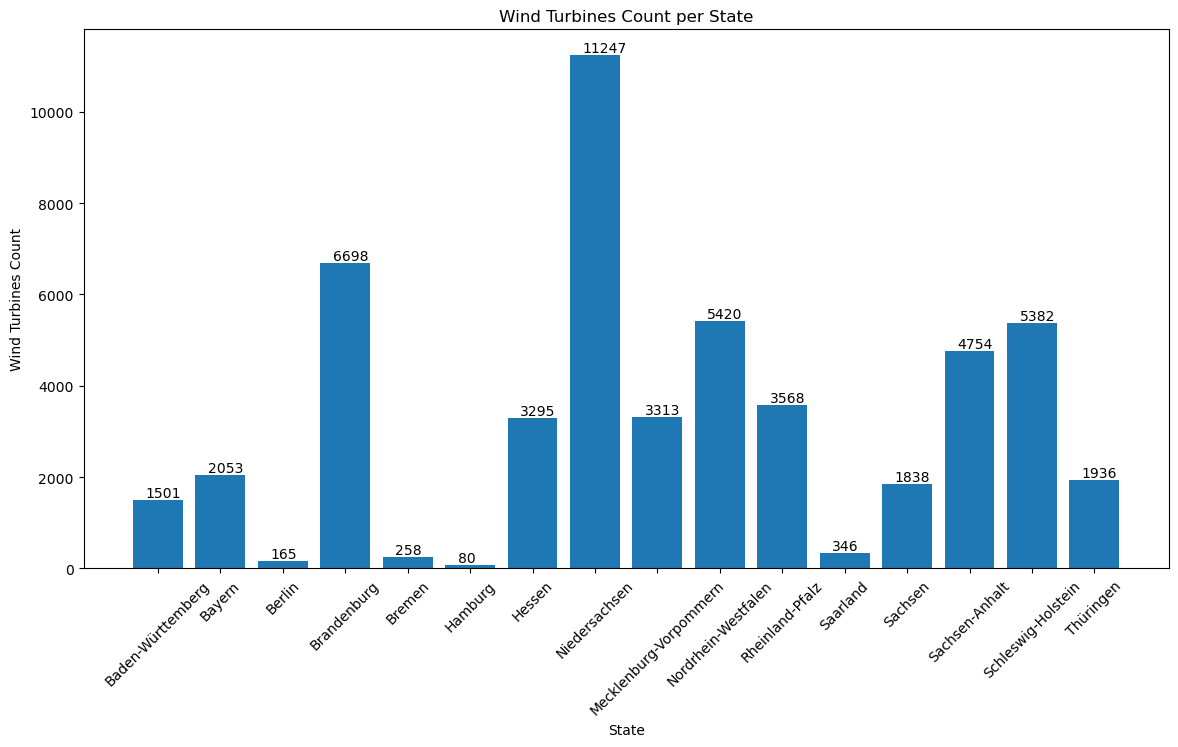

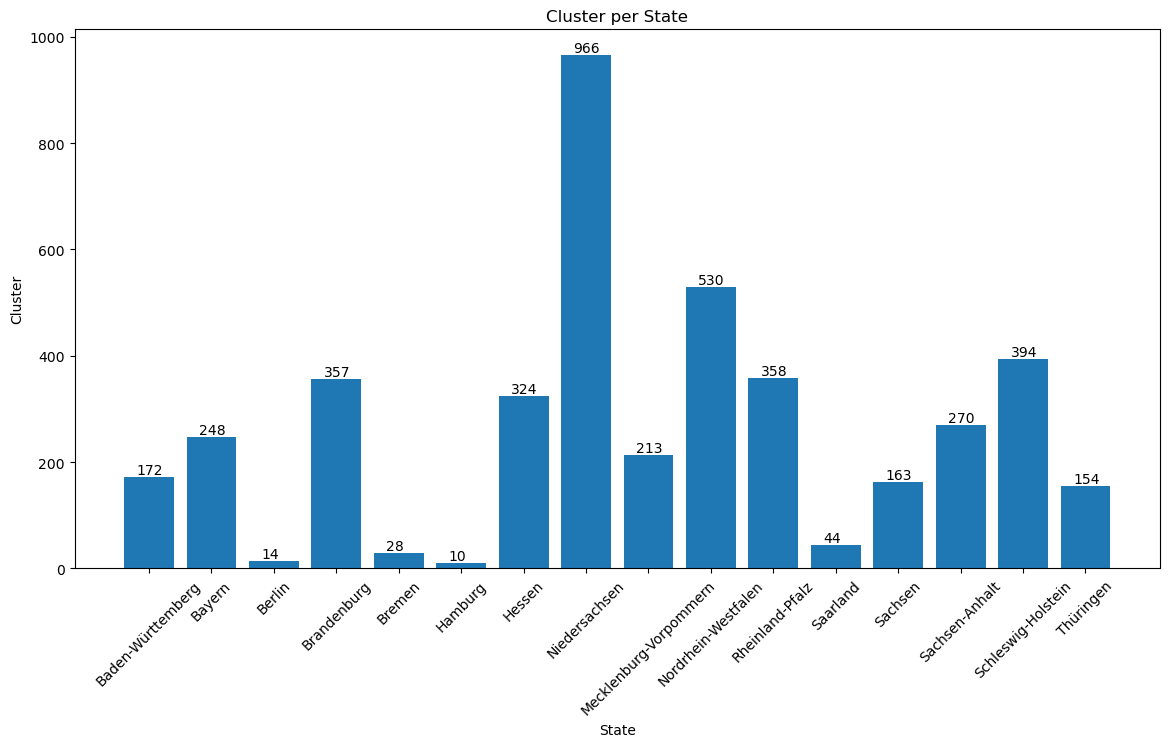

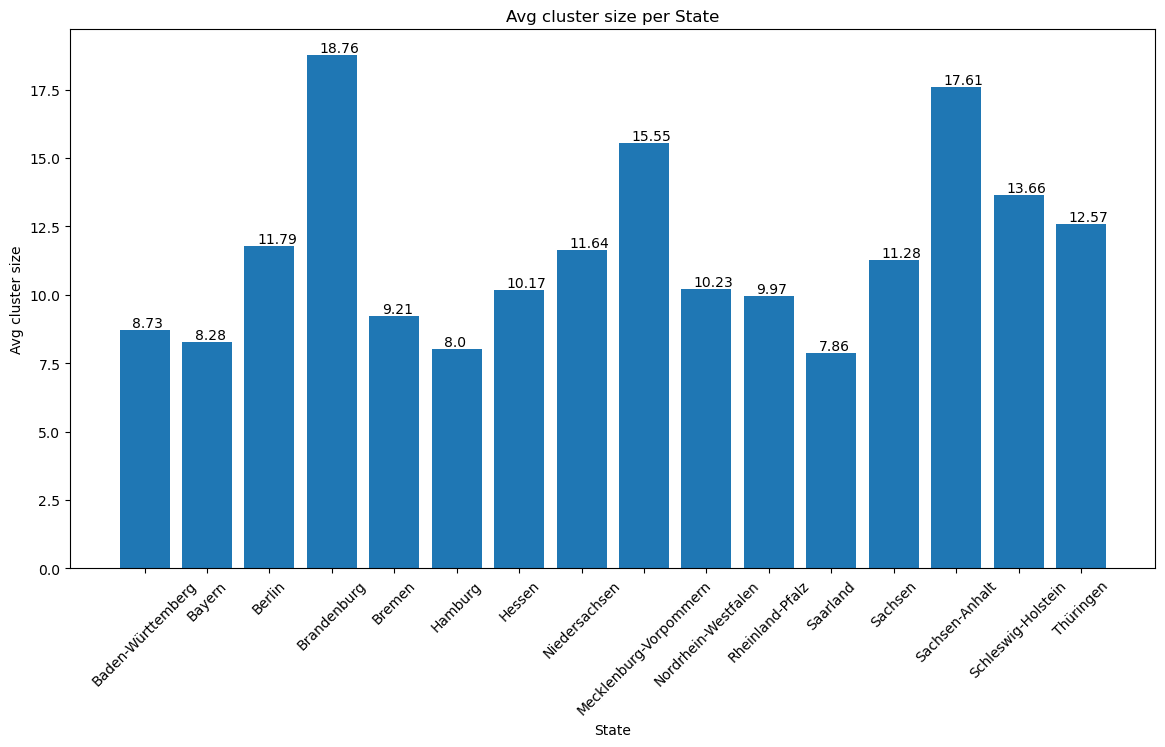

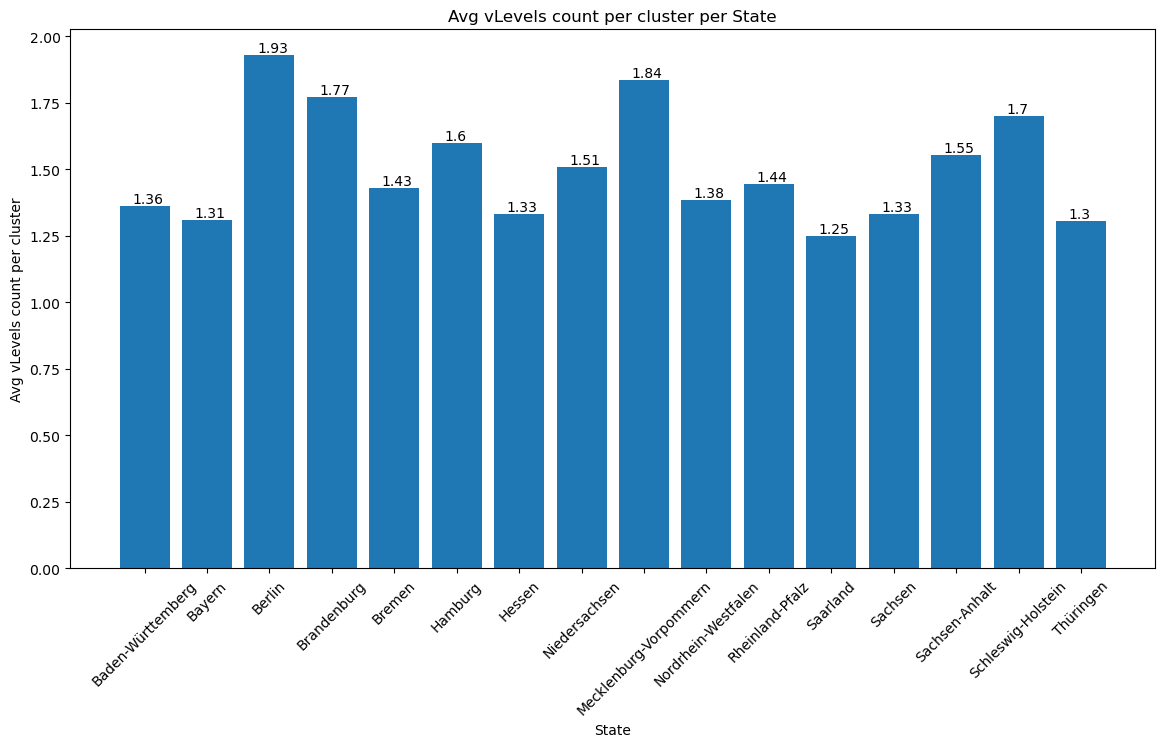

posx and posy should be finite values
posx and posy should be finite values


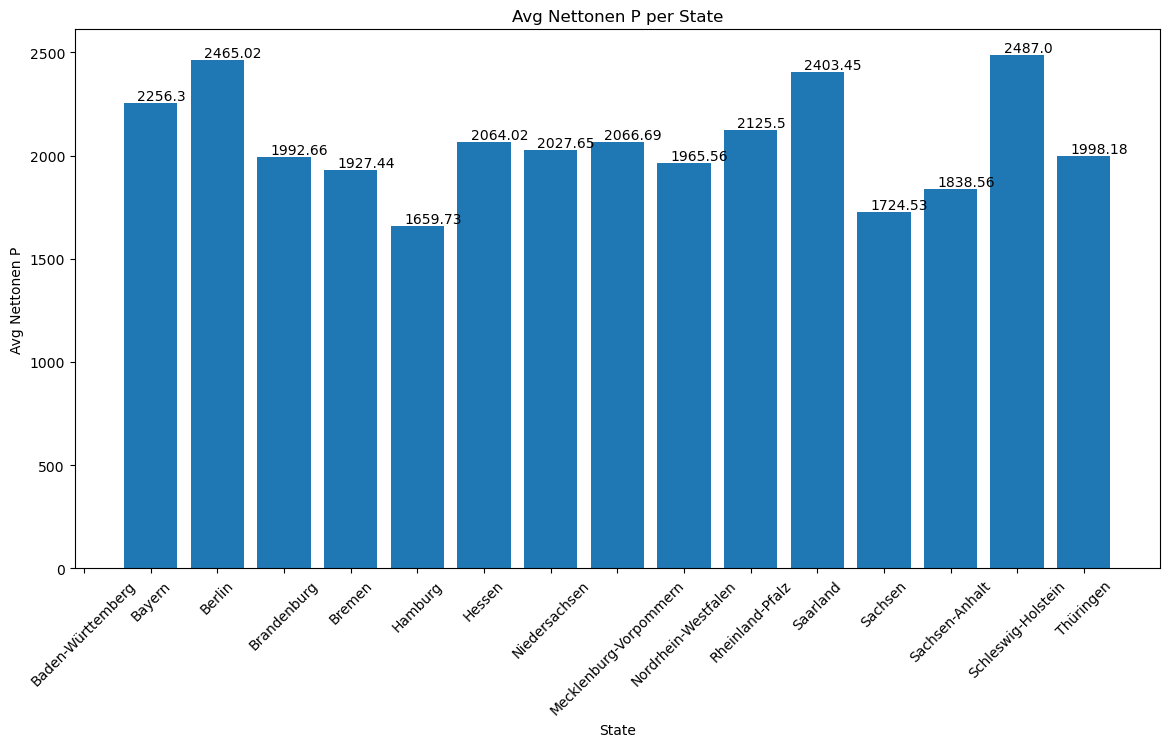

In [239]:

def plot_insights(df, column_name, title, y_label, plot_name):
    de_state_name_list = get_german_state_names(df)

    # Plot the percentage
    plt.figure(figsize=(14, 7))
    bars = plt.bar(de_state_name_list, df[column_name])
    plt.title(title)
    plt.ylabel(y_label)
    plt.xlabel("State")
    plt.xticks(rotation=45)

    # Add y-axis values to bars
    for bar in bars:
        yval = bar.get_height()
        plt.text(bar.get_x() + bar.get_width()/4, yval, round(yval, 2), va='bottom')  # va: vertical alignment

    # Save the plot
    plt.savefig(PLOT_SAVE_PATH + plot_name, dpi=INSIGHTS_PLOT_DPI, bbox_inches='tight')    
    # plt.show()

column_names = ["Wind Turbines Count", "Cluster", "Avg cluster size", "Avg vLevels count per cluster", "Avg Nettonen P"]
for column_name in column_names:        
    plot_id = str(uuid.uuid4())
    plot_insights(insights_df, column_name, f"{column_name} per State", column_name, f"wp_cluster_insights_plot_wt_{column_name}_{plot_id}.png")
    # w = input("any key to continue...") # for development

    # break # for development only execute one iteration

clear_output()